# Objective
This research has two objectives:
1. Replicate the results of the reference paper **"Inside insider trading: Patterns & discoveries from a large scale exploratory analysis"** by A. Tamersoy et al. [1](https://poloclub.github.io/polochau/insider/asonam13_insider.pdf) on 150 random S&P 500 companies from 1993 to December 2020. Insider trading data will be analysed from temporal and network-centric aspects.
2. Produce a data pipeline to automate the scraping and cleaning of Form 4 data as much as possible. Large-scale analysis of Form 4 data only began in 2012 by the reference paper.

In [11]:
# Essential imports and constants
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from pandas_datareader import data
import sqlite3 as sql
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sb; sb.set()
import requests, time, datetime, re, math, pickle, os
from multiprocessing import Pool
plt.style.use('default')

# if executed locally
BASE_DRIVE_LINK = ''
TEST = 'Rationale/test.csv'
TICKER = 'Metadata/ticker.txt'
FORM4_LINK = 'Database/form4_data.csv'
FORM4_LINK_XML = 'Database/form4_data_xml.csv'
FORM4_LINK_HTM = 'Database/form4_data_htm.csv'
FORM4_LINK_TXT = 'Database/form4_data_txt.csv'
FORM4_DETAIL = 'Database/form4_detail.csv' 
FORM4_DETAIL_XML = 'Database/form4_detail_xml.csv'
FORM4_DETAIL_CLEAN = 'Database/form4_detail_clean.csv'
FORM4_DETAIL_HTM = 'Database/form4_detail_htm.csv'
FORM4_DETAIL_TXT = 'Database/form4_detail_txt.csv'
FORM4_TX = 'Database/form4_tx.csv'
FORM4_TX_XML = 'Database/form4_tx_xml.csv'
FORM4_TX_CLEAN = 'Database/form4_tx_clean.csv'
FORM4_TX_HTM = 'Database/form4_tx_htm.csv'
FORM4_TX_TXT = 'Database/form4_tx_txt.csv'
META_DJ30 = 'Metadata/ticker_dj30.txt' 
META_SP500 = 'Metadata/ticker_sp500.txt'
META_SP500_RAN = 'Metadata/ticker_sp500_ran.txt'
CODE_EXTRACT = 'DataProcessingPipelining/extract_file.sh'
CODE_EXTRACT_ONE = 'DataProcessingPipelining/extract_1_quarter.sh'
CODE_EXTRACT_NOPAR = 'DataProcessingPipelining/extract_noPAR.sh'
LOG_LINK = 'Database/extract_link_log.txt'
LOG_NETWORK = 'Database/network_log.txt'

In [46]:
# if executed on Google Colab
from google.colab import drive
drive.mount('/content/drive')

BASE_DRIVE_LINK = '/content/drive/My Drive/URECA/'
FORM4_LINK = BASE_DRIVE_LINK + 'Database/form4_data.csv'
FORM4_LINK_XML = BASE_DRIVE_LINK + 'Database/form4_data_xml.csv'
FORM4_LINK_HTM = BASE_DRIVE_LINK + 'Database/form4_data_htm.csv'
FORM4_LINK_TXT = BASE_DRIVE_LINK + 'Database/form4_data_txt.csv'
FORM4_DETAIL = BASE_DRIVE_LINK + 'Database/form4_detail.csv'
FORM4_DETAIL_XML = BASE_DRIVE_LINK + 'Database/form4_detail_xml.csv'
FORM4_DETAIL_CLEAN = BASE_DRIVE_LINK + 'Database/form4_detail_clean.csv'
FORM4_DETAIL_HTM = BASE_DRIVE_LINK + 'Database/form4_detail_htm.csv'
FORM4_DETAIL_TXT = BASE_DRIVE_LINK + 'Database/form4_detail_txt.csv'
FORM4_TX = BASE_DRIVE_LINK + 'Database/form4_tx.csv'
FORM4_TX_XML = BASE_DRIVE_LINK + 'Database/form4_tx_xml.csv'
FORM4_TX_CLEAN = BASE_DRIVE_LINK +'Database/form4_tx_clean.csv'
FORM4_TX_HTM = BASE_DRIVE_LINK + 'Database/form4_tx_htm.csv'
FORM4_TX_TXT = BASE_DRIVE_LINK + 'Database/form4_tx_txt.csv'
META_DJ30 = BASE_DRIVE_LINK + 'Metadata/ticker_dj30.txt' 
META_SP500 = BASE_DRIVE_LINK + 'Metadata/ticker_sp500.txt'
META_SP500_RAN = BASE_DRIVE_LINK + 'Metadata/ticker_sp500_ran.txt'
TEST = BASE_DRIVE_LINK + 'Rationale/test.csv'
TICKER = BASE_DRIVE_LINK + 'Metadata/ticker.txt'
CODE_EXTRACT = BASE_DRIVE_LINK + 'DataProcessingPipelining/extract_file.sh'
CODE_EXTRACT_ONE = BASE_DRIVE_LINK + 'DataProcessingPipelining/extract_1_quarter.sh'
CODE_EXTRACT_NOPAR = BASE_DRIVE_LINK + 'DataProcessingPipelining/extract_noPAR.sh'
LOG_LINK = BASE_DRIVE_LINK + 'Database/extract_link_log.txt'
LOG_NETWORK = BASE_DRIVE_LINK + 'Database/network_log.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# snippet to download files
from google.colab import files
files.download('<filename here>')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Methodology

## Rationale for Using GNU Parallel
Experimenting with GNU Parallel. For SEC EDGAR file, only 10 requests per second are allowed. To test GNU Parallel, https://httpbin.org/#/Dynamic_data is used. 10 API calls that will delay 5 seconds are launched by curl in parallel. The results are obtained in 6s, which is a good estimate that GNU parallel is functioning.

In [ ]:
%%bash
seq 10 | time parallel -j10 'curl -X GET "https://httpbin.org/delay/5" -H "accept: application/json"'

{
  "args": {}, 
  "data": "", 
  "files": {}, 
  "form": {}, 
  "headers": {
    "Accept": "application/json", 
    "Host": "httpbin.org", 
    "User-Agent": "curl/7.68.0", 
    "X-Amzn-Trace-Id": "Root=1-60365028-2c22436a65bb09cd017d013f"
  }, 
  "origin": "155.69.175.63", 
  "url": "https://httpbin.org/delay/5"
}
{
  "args": {}, 
  "data": "", 
  "files": {}, 
  "form": {}, 
  "headers": {
    "Accept": "application/json", 
    "Host": "httpbin.org", 
    "User-Agent": "curl/7.68.0", 
    "X-Amzn-Trace-Id": "Root=1-60365028-6b55be27021de3d366bd4b5c"
  }, 
  "origin": "155.69.175.63", 
  "url": "https://httpbin.org/delay/5"
}
{
  "args": {}, 
  "data": "", 
  "files": {}, 
  "form": {}, 
  "headers": {
    "Accept": "application/json", 
    "Host": "httpbin.org", 
    "User-Agent": "curl/7.68.0", 
    "X-Amzn-Trace-Id": "Root=1-60365028-5e141fe6713b019911066cc7"
  }, 
  "origin": "155.69.175.63", 
  "url": "https://httpbin.org/delay/5"
}
{
  "args": {}, 
  "data": "", 
  "files": {},

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   318  100   318    0     0     52      0  0:00:06  0:00:06 --:--:--    78
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (7) Failed to connect to 1 port 80: Connection refused
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   318  100   318    0     0     52      0  0:00:06  0:00:06 --:--:--    78
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:

CalledProcessError: Command 'b'seq 10 | time parallel -j10 \'curl -X GET "https://httpbin.org/delay/5" -H "accept: application/json"\'\n'' returned non-zero exit status 10.

As an extension, API calls that will have delays from 1 to 15 seconds are made. With GNU Parallel, curl obtains the data in 18 seconds, showing that it does exhibit parallel behaviour.

In [ ]:
%%bash
seq 15 | time parallel -j10 'curl -X GET "https://httpbin.org/delay/{}" -H "accept: application/json" -N'

{
  "args": {}, 
  "data": "", 
  "files": {}, 
  "form": {}, 
  "headers": {
    "Accept": "application/json", 
    "Host": "httpbin.org", 
    "User-Agent": "curl/7.68.0", 
    "X-Amzn-Trace-Id": "Root=1-60364d76-294f327a183efe5e4fddec92"
  }, 
  "origin": "155.69.175.63", 
  "url": "https://httpbin.org/delay/1"
}
{
  "args": {}, 
  "data": "", 
  "files": {}, 
  "form": {}, 
  "headers": {
    "Accept": "application/json", 
    "Host": "httpbin.org", 
    "User-Agent": "curl/7.68.0", 
    "X-Amzn-Trace-Id": "Root=1-60364d76-751ac2a11a21f0ec69fdf1b4"
  }, 
  "origin": "155.69.175.63", 
  "url": "https://httpbin.org/delay/2"
}
{
  "args": {}, 
  "data": "", 
  "files": {}, 
  "form": {}, 
  "headers": {
    "Accept": "application/json", 
    "Host": "httpbin.org", 
    "User-Agent": "curl/7.68.0", 
    "X-Amzn-Trace-Id": "Root=1-60364d76-5c87682d567d70e5040f4282"
  }, 
  "origin": "155.69.175.63", 
  "url": "https://httpbin.org/delay/3"
}
{
  "args": {}, 
  "data": "", 
  "files": {},

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   318  100   318    0     0    155      0  0:00:02  0:00:02 --:--:--   155
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   318  100   318    0     0    105      0  0:00:03  0:00:03 --:--:--   105
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   318  100   318    0     0     78      0  0:00:04  0:00:04 --:--:--    78
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   318  100   318    0     0     62      0  0:00:05  0:00:05 --:--:--    78
  % Total    % Received % Xferd  Average Speed   Tim

`curl` can be configured to not buffer the outputs while the execution is ongoing with `-N` option

In [ ]:
%%bash
curl -X GET "https://httpbin.org/drip?duration=2&numbytes=10&code=200&delay=2" -H "accept: application/octet-stream" -N

**********

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    10  100    10    0     0      2      0  0:00:05  0:00:04  0:00:01     2


## Rationale for Using Scripting
If Form 4 files from 1993 to 2021 are all downloaded without processing on-the-fly, files will be at least 2GB. However, not all data are needed for data processing. To extract the right data for analysis, Bash script is used. 
  
The typical way of handling data would be to read in the data files and process them by using Pandas. However, this process may not be suitable for large files due to memory and time complexities (paging will create bottleneck in bringing into the physical memory)

*Note: in this research, on-the-fly processing is carried out via Bash Script (see Section 3). This section is relevant for future studies that attempt to keep the files.*

The script below generates a csv file with 2.55GB data, where there are 23 columns and 50 million rows of data. Each row of data is 51 bytes. The file size is the typical file size of all Form 4 files in SEC EDGAR

In [ ]:
%%bash
# Add header for easier reference
echo "digit_1,mul2,digit_2,digit_3,digit_4,digit_5,mod3,mod5,doubledigit_1,digit_6,digit_7,digit_8,mod4,doubledigit_2,digit_9,digit_10,digit_11,mod7,triple,doubledigit_3,digit12,digit13,digit14" | tee test.csv
for i in $(seq 1 1 50000000); do 
    tmp=$(($i%10));
    echo $tmp,$(($(($i*2))%10)),$tmp,$tmp,$tmp,$tmp,$(($tmp % 3)),$(($tmp % 5)),$tmp$tmp,$tmp,$tmp,$tmp,$(($tmp % 4)),$tmp$tmp,$tmp,$tmp,$tmp,$(($tmp % 7)),$tmp$tmp$tmp,$tmp$tmp,$tmp,$tmp,$(($tmp % 4)); 
done | tee -a test.csv | awk 'FNR < 15'

# using awk instead of head as it is asynchronous [https://unix.stackexchange.com/questions/47932/how-do-i-use-tee-to-redirect-to-grep]
# command for awk [https://www.unix.com/shell-programming-and-scripting/82416-printing-first-n-lines-file-without-using-head.html]

digit_1,mul2,digit_2,digit_3,digit_4,digit_5,mod3,mod5,doubledigit_1,digit_6,digit_7,digit_8,mod4,doubledigit_2,digit_9,digit_10,digit_11,mod7,triple,doubledigit_3,digit12,digit13,digit14
1,2,1,1,1,1,1,1,11,1,1,1,1,11,1,1,1,1,111,11,1,1,1
2,4,2,2,2,2,2,2,22,2,2,2,2,22,2,2,2,2,222,22,2,2,2
3,6,3,3,3,3,0,3,33,3,3,3,3,33,3,3,3,3,333,33,3,3,3
4,8,4,4,4,4,1,4,44,4,4,4,0,44,4,4,4,4,444,44,4,4,0
5,0,5,5,5,5,2,0,55,5,5,5,1,55,5,5,5,5,555,55,5,5,1
6,2,6,6,6,6,0,1,66,6,6,6,2,66,6,6,6,6,666,66,6,6,2
7,4,7,7,7,7,1,2,77,7,7,7,3,77,7,7,7,0,777,77,7,7,3
8,6,8,8,8,8,2,3,88,8,8,8,0,88,8,8,8,1,888,88,8,8,0
9,8,9,9,9,9,0,4,99,9,9,9,1,99,9,9,9,2,999,99,9,9,1
0,0,0,0,0,0,0,0,00,0,0,0,0,00,0,0,0,0,000,00,0,0,0
1,2,1,1,1,1,1,1,11,1,1,1,1,11,1,1,1,1,111,11,1,1,1
2,4,2,2,2,2,2,2,22,2,2,2,2,22,2,2,2,2,222,22,2,2,2
3,6,3,3,3,3,0,3,33,3,3,3,3,33,3,3,3,3,333,33,3,3,3
4,8,4,4,4,4,1,4,44,4,4,4,0,44,4,4,4,4,444,44,4,4,0


Consider loading the whole dataset into csv file just to get those rows with 'triple' = 111

For Pandas, the naive approach would be to load the whole dataset into a variable `df`, and then use Boolean operations and masking to obtain the required data.

In [ ]:
%%time
data = pd.read_csv(TEST, header = 0)
df = data.loc[data['triple']==111, :]
display(df)

MemoryError: Unable to allocate 8.57 GiB for an array with shape (23, 50000000) and data type int64

`MemoryError` occured as the physical memory on the local machine is insufficient for the whole dataset. An approach to circumvent this issue is to load the file in chunks or to use appropriate data types to add

In [ ]:
a = datetime.datetime.now()
df_full = pd.DataFrame()
for chunk in pd.read_csv(TEST, header = 0, chunksize = 100000):
    df = chunk.loc[(chunk['triple'] == 111), :]
    df_full = pd.concat([df_full, df], axis = 0)
b = datetime.datetime.now()
display(df_full)
print("Total Time Taken:", (b-a).total_seconds())

,digit_1,mul2,digit_2,digit_3,digit_4,digit_5,mod3,mod5,doubledigit_1,digit_6,...,doubledigit_2,digit_9,digit_10,digit_11,mod7,triple,doubledigit_3,digit12,digit13,digit14
0,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
10,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
20,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
30,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
40,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49999950,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
49999960,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
49999970,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
49999980,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1


Total Time Taken: 131.005842


To process 2.5GB of data, Pandas took approximately 2 minutes 10 seconds (131.005842 seconds). Consider using bash script with awk, which streams and processes data line by line

In [ ]:
%%bash
time awk 'BEGIN {FS=","} {if (($19 == 111))
    print $0;
}' 'Rationale/test.csv' >buffer.csv


real	0m45.338s
user	0m42.406s
sys	0m2.859s


In [ ]:
a = datetime.datetime.now()
df_all_bash = pd.read_csv('buffer.csv', header = 0)
display(df_all_bash)
b = datetime.datetime.now()
print((b-a).total_seconds())

,1,2,1.1,1.2,1.3,1.4,1.5,1.6,11,1.7,...,11.1,1.11,1.12,1.13,1.14,111,11.2,1.15,1.16,1.17
0,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
1,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
2,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
3,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
4,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999994,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
4999995,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
4999996,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
4999997,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1


6.468974


Adding the processing and loading time of the script approach yields less than 55 seconds, compared with 131 seconds by using Pandas approach. The script approach takes less than 45% of the time taken by Pandas approach.

This quick example illustrates the need for pre-filtering of data instead of loading the whole dataset into the physical memory. Although there are other variables that influence the ability to load DataFrames (eg. data types used to store each datum, number of processors on the machine), this example is intended to just explain the rationale of using scripting to filter data

An alternative method is to store the data in SQL database and filter the necessary data before reading them. The following example shows this approach by using SQLite, a small, portable and full-featured database engine. SQLite is used in this example for two reasons:
1. For easy replication of this research
2. It has lower operational overhead than other database engines such as MySQL and PostgreSQL

In [ ]:
%%time
conn = sql.connect('rationale_use_script.db')

for chunk in pd.read_csv('Rationale/test.csv', header = 0, chunksize = 1000000):
    chunk.to_sql('rationale_use_script', conn, index=False, if_exists = 'append')

Wall time: 7min 33s


In [ ]:
# Verify that all data are transferred
query = """
SELECT COUNT(*)
FROM rationale_use_script;
"""
count = pd.read_sql_query(query, conn)
print(count)

   COUNT(*)
0  50000000


In [ ]:
import datetime
a = datetime.datetime.now()
query = """
SELECT *
FROM rationale_use_script
WHERE triple=111;
"""
df_full_sql = pd.read_sql_query(query, conn)
display(df_full_sql)
b = datetime.datetime.now()
print("Total Time Taken:", (b-a).total_seconds())

,digit_1,mul2,digit_2,digit_3,digit_4,digit_5,mod3,mod5,doubledigit_1,digit_6,...,doubledigit_2,digit_9,digit_10,digit_11,mod7,triple,doubledigit_3,digit12,digit13,digit14
0,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
1,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
2,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
3,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
4,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
4999996,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
4999997,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1
4999998,1,2,1,1,1,1,1,1,11,1,...,11,1,1,1,1,111,11,1,1,1


Total Time Taken: 129.08036


Notice that the SQLite approach takes approximately 2 minutes 9 seconds (129.08036 seconds). 
  
In summary, 

|Approach | Time (rounded to nearest sec)| Approximate Ratio
--- | --- | ---
CSV | 131 | 2.52
Script | 52 | 1
SQL | 129 | 2.48

# Data Collection
To obtain data, three major actions are taken:  
1.	Identify the storage of Form 4 files in EDGAR archive to design a scraping plan.
2.	Determine the target companies to explore and scrape.
3.	Scrape the information from the Form 4 files.

## Scraping XML Links
Insider trading filings are kept in US Securities and Exchange Commission (SEC) in Electronic Data Gathering, Analysis, and Retrieval system (EDGAR), the primary system for companies and other entities to submit documents [1](https://www.sec.gov/edgar/about). Since all insider trading activities must be reported to SEC EDGAR via Form 4, insider trading analysis can be performed by scraping the website.
  
SEC EDGAR website compiles data in the following way:
- The Form 4 files since 1993 are stored in SEC EDGAR. 
- The Form 4 files are compiled into a folder each quarter of the year. To locate all of these files, EDGAR uses an index `idx` file to track the reporting companies, dates and links regarding each Form 4 file.
Hence, to quicken the data collection process, the index files will be scraped by substituting the year and quarter into the link, and obtaining the link by cURL utility. The website link has the pattern   
`https://www.sec.gov/Archives/edgar/full-index/[filing year]/QTR[filing quarter]/form.idx`
  
However, SEC EDGAR has a traffic limit of 10 requests per second. Exceeding traffic limit will cause IP block for 10 minutes. While the offered traffic limit is decent, it takes around 500 seconds to scrap just one quarter (if the quarter is the first or second quarter). Parallel execution is preferred.
  
Scraping of XML files is done in `extract.sh`. Note that a string parameter containing CIKs separated by '|' is passed into the file for filtering.

In [ ]:
%%bash -s "$CODE_EXTRACT"
cat $1

#!/bin/bash
read CIKs;

scrapDetailsFromLink() {
    temp=$(echo $4 | sed -e 's/-//g');
    xml_file=$(curl -s $4 | sed -ne '0,/<FILENAME>/s/<FILENAME>\(.*\)/\1/p');
    if [[ $? == 0 ]]; then
        new_link=$(echo $temp | sed -e "s|.txt|/$xml_file|");
        printf "%s\b|%s|%s|%s\n" "$1" $2 $3 $new_link;
    else
        printf "%s\b|%s|%s|%s\n" "$1" $2 $3 $temp;
    fi
    sleep 1;
}
export -f scrapDetailsFromLink

for i in $(seq 1993 1 2020); 
do
    for j in $(seq 1 1 4);
    do
        idx_file="https://www.sec.gov/Archives/edgar/full-index/$i/QTR$j/form.idx"
        if curl -o /dev/null --silent --fail --head $idx_file; then
            echo "Reading idx file for $i-QTR$j"
            SECONDS=0;
            dir_date=$(echo $idx_file | sed -rne "s|.*([0-9]{4})/QTR([1-4]).*|\1-QTR\2|p")
            curl -s $idx_file | grep -E "^4[[:space:]]" | grep -Ew $CIKs |
            awk -v home_link="https://www.sec.gov/Archives/" 'BEGIN{OFS="::"; ORS="\n"}
                {for(i=2;i<NF-2;

## Determine the Target Companies
This exploration focuses on **150 S&P 500 companies.** 
- As each company has a corresponding Central Index Key (CIK) and a Ticker Symbol, [ticker data](https://www.sec.gov/include/ticker.txt) is obtained from SEC EDGAR to obtain information about these companies.
- To determine a clearer company domain to explore, Dow Jones 30 and S&P 500 companies are explored
    - Dow Jones 30 companies are obtained from [Wikipedia](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average)
    - S&P 500 companies are obtained from [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)

In [ ]:
# Obtain ticker data
ticker_cik = pd.read_table(TICKER, names = ['Ticker', 'CIK'])
ticker_cik.Ticker = ticker_cik.apply(lambda x: str(x.Ticker).upper(), axis = 1)
ticker_cik.set_index('Ticker', inplace = True)

### Dow Jones 30

In [ ]:
dj_companies = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
dj_companies = dj_companies.loc[:,['Company', 'Symbol']].set_index('Symbol')

In [ ]:
!curl -s https://www.sec.gov/include/ticker.txt >ticker.txt

In [ ]:
dj_companies = dj_companies.join(ticker_cik, how = 'inner')
grep_pat = '|'.join(dj_companies.CIK.astype(str).to_list())
with open(META_DJ30, 'w') as f:
    f.write("%s" % grep_pat)
print(grep_pat)
dj_companies.head()

320193|318154|4962|12927|18230|1108524|858877|93410|1744489|1751788|886982|354950|773840|51143|50863|200406|19617|21344|63908|66740|310158|789019|320187|80424|86312|731766|1403161|732712|1618921|104169


,Company,CIK
AAPL,Apple Inc.,320193
AMGN,Amgen,318154
AXP,American Express,4962
BA,Boeing,12927
CAT,Caterpillar Inc.,18230


### S&P 500

In [ ]:
sp_companies = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp_companies = sp_companies.loc[:, ['Symbol', 'Security']].set_index('Symbol')
sp_companies = sp_companies.merge(ticker_cik, left_index = True, right_index = True)

In [ ]:
grep_pat = '|'.join(sp_companies.CIK.astype(str).to_list())
with open(META_SP500, 'w') as f:
    f.write("%s" % grep_pat)

In [ ]:
sp_companies_random = sp_companies.sample(n=150)
grep_pat = '|'.join(sp_companies_random.CIK.astype(str).to_list())
with open(META_SP500_RAN, 'w') as f:
    f.write("%s" % grep_pat)

In this research, 150 random companies on S&P500 are chosen.

In [ ]:
%%bash -s "$META_SP500" "CODE_EXTRACT"
cat $1 | sh $2

cat: Metadata/ticker_sp500_ran.txt: No such file or directory
sh: 0: Can't open extract.sh


### Linking to 3.1: Shortening the Data Processing and Pipelining Process
GNU Parallel is used to improve the existing `extract.sh` before execution. However, as traffic limit must be considered, the total request-response time is measured. To measure this, the duration for a file is first measured. This approach and command is illustrated by [Joseph Scott](https://blog.josephscott.org/2011/10/14/timing-details-with-curl/):  
- Use the request-response information to obtain time-related measurements and output into `curl-format.txt`
- Calculate the time with `-w` option  
An example is shown below

In [ ]:
%%bash
wget http://ftp.gnu.org/gnu/parallel/parallel-20210522.tar.bz2
sudo tar xjf parallel-20210522.tar.bz2
cd parallel-20210522
sudo ./configure && make
sudo make install
cd

In [ ]:
%%bash 
curl -w "@curl-format.txt" -o /dev/null -s "https://www.sec.gov/Archives/edgar/data/320193/000032019320000101/wf-form4_160565582610158.xml"

     time_namelookup:  0.026844s
        time_connect:  0.033290s
     time_appconnect:  0.062047s
    time_pretransfer:  0.062207s
       time_redirect:  0.000000s
  time_starttransfer:  0.082111s
                     ----------
          time_total:  0.082261s


Assuming an upper limit of 0.1s for each call. Hence, within 1 second, 10 requests can be launched -- the **maximum** traffic limit of SEC EDGAR. GNU Parallel can be run, but it needs to be a delay for at least 0.92 seconds for each job. For easier coding, a delay of 1 second is used. `extract.sh` is displayed in the cell above, under section 3.1

In [ ]:
%%bash -s "$CODE_EXTRACT_ONE"
cat $1

#!/bin/bash
read CIKs;
user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"

scrapDetailsFromLink() {
    temp=$(echo $4 | sed -e 's/-//g');
    xml_file=$(curl -s $4 | sed -ne '0,/<FILENAME>/s/<FILENAME>\(.*\)/\1/p');
    if [[ $? == 0 ]]; then
        new_link=$(echo $temp | sed -e "s|.txt|/$xml_file|");
        printf "%s\b|%s|%s|%s\n" "$1" $2 $3 $new_link;
    else
        printf "%s\b|%s|%s|%s\n" "$1" $2 $3 $temp;
    fi
    sleep 1;
}
export -f scrapDetailsFromLink

for i in $(seq 2010 1 2010); 
do
    for j in $(seq 1 1 1);
    do
        idx_file="https://www.sec.gov/Archives/edgar/full-index/$i/QTR$j/form.idx"
        if curl -A $user_agent -o /dev/null --silent --fail --head $idx_file; then
            echo "Reading idx file for $i-QTR$j"
            SECONDS=0;
            dir_date=$(echo $idx_file | sed -rne "s|.*([0-9]{4})/QTR([1-4]).*|\1-QTR\2|p")
            curl -s $idx_file | grep -E "^4[[:space

In [ ]:
%%bash -s "$META_DJ30" "$CODE_EXTRACT_ONE"
cat $1 | bash $2

HTTP/2 200 
content-type: application/octet-stream
etag: "b978e6511ba0ba13b75e575b0ec94c15"
last-modified: Sat, 15 May 2021 06:24:22 GMT
server: AmazonS3
x-amz-id-2: xsnvaf+pL/5sXj7X7JXa2QuF2c7R/EhRvq6v5jMy3Mt3ZZCP0Mz5jFVH4Den1BNSZbewWmZkuNg=
x-amz-meta-mode: 33188
x-amz-meta-s3cmd-attrs: uid:504/gname:fitrprnt/uname:fitrprnt/gid:504/mode:33152/mtime:1621059776/atime:1621059780/md5:b978e6511ba0ba13b75e575b0ec94c15/ctime:1621059860
x-amz-replication-status: COMPLETED
x-amz-request-id: 505XTV9G5DAG6N37
x-amz-version-id: u8XBKKZqeNrnmM2.uBClSAwb1iZLiCh2
x-content-type-options: nosniff
x-frame-options: SAMEORIGIN
x-xss-protection: 1; mode=block
date: Sun, 16 May 2021 06:33:28 GMT
strict-transport-security: max-age=31536000 ; includeSubDomains ; preload

Reading idx file for 2010-QTR1
Runtime for 2010-QTR1: 139
./trading_2010-QTR1.csv is appended into database document


In [ ]:
%%bash -s "$META_DJ30" "$CODE_EXTRACT_ONE"
cat $1 | bash $2

Reading idx file for 2010-QTR1
Runtime for 2010-QTR1: 138
./trading_2010-QTR1.csv is appended into database document


In [ ]:
%%bash
wc -l form4_data.csv

1146 form4_data.csv


In [ ]:
%%bash -s "$CODE_EXTRACT_NOPAR"
cat $1

#!/bin/sh
read CIKs;
for i in $(seq 2010 1 2010); 
do
    for j in $(seq 1 1 1);
    do
        idx_file="https://www.sec.gov/Archives/edgar/full-index/$i/QTR$j/form.idx"
        if curl -o /dev/null --silent --fail --head $idx_file; then
            echo "Reading idx file for $i-QTR$j"
            SECONDS=0;
            dir_date=$(echo $idx_file | sed -rne "s|.*([0-9]{4})/QTR([1-4]).*|\1-QTR\2|p")
            curl -s $idx_file | grep -E "^4[[:space:]]" | grep -Ew $CIKs |
            awk -v home_link="https://www.sec.gov/Archives/" 'BEGIN{OFS=":"; ORS="\n"}
                {for(i=2;i<NF-2;i++) printf("%s ", $(i))
                print "", $(NF-2), $(NF - 1), home_link$(NF)}' |
            while IFS=: read -r company cik date link; do
                sleep 0.1000
                xml_file=`curl -s $link | sed -ne '0,/<FILENAME>/s/<FILENAME>\(.*\)/\1/p' `
                temp=`echo $link | sed -e 's/-//g'`
                new_link=`echo $temp | sed -e "s|.txt|/$xml_file|"`
               

In [ ]:
%%bash -s "$META_DJ30" "$CODE_EXTRACT_NOPAR"
cat $1 | bash $2

Reading idx file for 2010-QTR1
Runtime: 748
./trading_2010-QTR1.csv is appended into database document


In [ ]:
%%bash
wc -l data.csv

1146 data.csv


Based on the output from the cells for both approaches, the table below is created to compare their efficiencies.  Both approaches are within the 10 request per second limit.  

The table shows that there is a **fivefold** speedup when GNU Parallel is used appropriately

| Fetch | Link Fetching Period (seconds) | Rate of Fetching Request (request/s) | Ratio of Rate 
| ---- | :----: | :----: | :---:
| In Parallel | 0.12 | 8.30 | 5.4 
| Sequentially | 0.65 | 1.532 | 1 

## Extracting and Cleaning: Scraping Information from Form 4 Files

While all files that are labeled as Form 4 are extracted from SEC EDGAR, care must be taken that not all forms are in the same format.

As will be presented below, most Form 4 files are in XML format. The same structure allows automated extraction. However, the other files require a different approach. 

The code section below shows the total number of Form 4 files and the number of files that are not in XML format. Other files could be in `htm` or `txt` format. In addition, some of the links scraped do not even have a file extension because the script executed in the previous section identifies the `<FILENAME>` tag in the `txt` file in order to locate the XML or HTM file.

Firstly, the actual scraping of the Form 4 files from SEC EDGAR and categorisation of the files according to its extensions (xml, htm or txt). Occassionally EDGAR will block curl request as it identifies the requestor as an automation bot. As such, the HTTP code is obtained from `curl`. The script will keep requesting the same index file until the HTTP code is 200 (status 'OK').

Due to the same request blocking reason, the individual Form 4 files may not be retrieved with just one request. As such, after all index files are extracted, the script will identify file links that are incomplete, and will iterate through the list of incomplete links and request again. This process only ends when an iteration does not successfully reduce the pool of incomplete links

#### Extraction Process via Bash Script
1. 'extract_file.sh` will be run to scrape files from all years
2. After Step 1, 'recover.sh' is then run to recover the files
> This file keeps running until the pool of incomplete files remain the constant for one iteration. In each iteration of 'recover.sh', 'extract_recover.sh' will be called

In [5]:
%%bash -s "$META_SP500_RAN" "$CODE_EXTRACT"
cat "$1" | bash "$2"

Reading idx file for 1993-QTR1
Reading idx file for 1993-QTR2
Reading idx file for 1993-QTR3
Reading idx file for 1993-QTR4
Reading idx file for 1994-QTR1
Reading idx file for 1994-QTR2
Reading idx file for 1994-QTR3
Reading idx file for 1994-QTR4
Reading idx file for 1995-QTR1
Reading idx file for 1995-QTR2
Reading idx file for 1995-QTR3
Reading idx file for 1995-QTR4
Reading idx file for 1996-QTR1
Reading idx file for 1996-QTR2
Reading idx file for 1996-QTR3
Reading idx file for 1996-QTR4
Reading idx file for 1997-QTR1
Reading idx file for 1997-QTR2
Reading idx file for 1997-QTR3
Reading idx file for 1997-QTR4
Reading idx file for 1998-QTR1
Reading idx file for 1998-QTR2
Reading idx file for 1998-QTR3
Reading idx file for 1998-QTR4
Reading idx file for 1999-QTR1
Reading idx file for 1999-QTR2
Reading idx file for 1999-QTR3
Reading idx file for 1999-QTR4
Reading idx file for 2000-QTR1
Reading idx file for 2000-QTR2
Reading idx file for 2000-QTR3
Reading idx file for 2000-QTR4
Reading 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
%%bash -s "$FORM4_LINK_XML"
wc -l $1    # number of Form 4 files harvested

174387 Database/form4_data_xml.csv


2% of the files are non-XML files. Since there are three file types, three approaches are needed to scrap data. However, as the number of non-XML files is insignificant (as these extensions only exist in old Form 4 files), their extraction will be ignored, and more steps are illustrated for XML files. The extraction of the other two file types involves similar steps.

### Scrap Information from Each Form 
Form 4 files are stored in three formats: HTM, XML and txt files.  

This research scrapes the data from XML files with the help of Beautiful Soup. To begin with, the important attributes to be scraped are identified. An example of the XML file is used to explore the attributes

In [54]:
data = pd.read_csv(FORM4_LINK_XML, sep='|')

In [4]:
content = requests.get("https://www.sec.gov/Archives/edgar/data/318154/000118143104004871/rrd30540.xml").content
bs_content = bs(content, 'lxml')
print(bs_content.prettify())

<?xml version="1.0"?>
<html>
 <body>
  <ownershipdocument>
   <schemaversion>
    X0201
   </schemaversion>
   <documenttype>
    4
   </documenttype>
   <periodofreport>
    2004-01-27
   </periodofreport>
   <notsubjecttosection16>
    0
   </notsubjecttosection16>
   <issuer>
    <issuercik>
     0000318154
    </issuercik>
    <issuername>
     AMGEN INC
    </issuername>
    <issuertradingsymbol>
     AMGN
    </issuertradingsymbol>
   </issuer>
   <reportingowner>
    <reportingownerid>
     <rptownercik>
      0000904017
     </rptownercik>
     <rptownername>
      JOHNSON FRANKLIN P JR
     </rptownername>
    </reportingownerid>
    <reportingowneraddress>
     <rptownerstreet1>
      ONE AMGEN CENTER DRIVE
     </rptownerstreet1>
     <rptownerstreet2>
     </rptownerstreet2>
     <rptownercity>
      THOUSAND OAKS
     </rptownercity>
     <rptownerstate>
      CA
     </rptownerstate>
     <rptownerzipcode>
      91320-1799
     </rptownerzipcode>
     <rptownerstatedescri

A few observations are made:
- Each issuer (the reporting firm or representative) can file many Form 4
- Each reporter can file many Form 4, but the number of shares owned after the transaction is related to the reporter, not the issuer
- Each Form 4 is labeled with **an** Accession Number, which is composed of [three parts](https://www.sec.gov/edgar/searchedgar/accessing-edgar-data.htm):
    - CIK of the firm 
    - last two digits of the filing year
    - sequential count of submitted filings from that firm that year
- **Each** Form 4 file can have **multiple** transactions. This research will only focus on non-derivative transactions.
- This implies that each file has a unique Accession Number, which can assist in merging tables for exploratory analysis.

Firstly, the main table that details a Form 4 file for each entry is built. This file is stored in *form4_detail.csv*. Useful information includes

| Detail | Variable in DataFrame |
| :--- | :--- |
Trading Symbol | `trad_symbol`
Accession Number | `accession_no`
Form Number (to double-check if it is Form 4) | `form`
Reporter's name | `reporter_name`
Reporter's CIK | `reporter_cik`
Reporter's Title in the Company | `reporter_title`
Whether Trader is a Director | `is_director`
Whether Trader is an Officer | `is_officer`
Whether Trader is a Beneficial Owner (i.e. owns at least 10% of the company shares) | `is_beneficial_owner`
Whether Trader is none of the above three | `is_other`

In [2]:
def extract_xml(record):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"}
    content = requests.get(record['Link'], headers = headers).content
    bs_content = bs(content, 'lxml')
    time.sleep(0.04)
    accession_no = str(re.split('/', record['Link'])[-2])
    try:
        trad_symbol = bs_content.find("issuertradingsymbol").text
    except:
        print(record['Link'], '<issuertradingsymbol> not found. Link fails to be fetched')
        trad_symbol = ""  
    try:
        form = bs_content.find("documenttype").text
    except:
        print(record['Link'], '<documenttype> not found')
        form = np.NaN
    try:
        reporter_name = bs_content.find("rptownername").text.title()
    except:
        reporter_name = np.NaN
    try:
        reporter_cik = bs_content.find("rptownercik").text
    except:
        reporter_cik = np.NaN

    try:
        is_director = int(bs_content.find("isdirector").text)
    except:
        is_director = np.NaN
    
    try:
        is_officer = int(bs_content.find("isofficer").text)
    except:
        is_officer = np.NaN
    
    try:
        is_beneficial_owner = int(bs_content.find("istenpercentowner").text)
    except:
        is_beneficial_owner = np.NaN
    
    try:
        is_other = int(bs_content.find("isother").text)
    except:
        is_other = np.NaN
        
    try:
        reporter_title = bs_content.find("officertitle").text
    except:
        reporter_title = np.NaN
    return [trad_symbol, accession_no, form, reporter_name, reporter_cik, reporter_title, is_director, is_officer, is_beneficial_owner, is_other]

In [10]:
start = datetime.datetime.now()
batch_number = 1
for chunk in pd.read_csv(FORM4_LINK_XML, sep='|', chunksize=2000):
    chunk[['trad_symbol', 'accession_no', 'form', 'reporter_name', 'reporter_cik', 'reporter_title', 'is_director', 'is_officer', 'is_beneficial_owner', 'is_other']] = chunk.apply(extract_xml, axis = 1, result_type = 'expand')
    if batch_number == 1:
        chunk.to_csv(FORM4_DETAIL_XML, index=False, header=True, mode='w')
    else:
        chunk.to_csv(FORM4_DETAIL_XML, index=False, header=False, mode='a')
    print(f"batch {batch_number} completed")
    batch_number+=1
print("Completed execution")
end = datetime.datetime.now()
print(f'Duration {(end-start).total_seconds()}')

batch 1 completed
batch 2 completed
batch 3 completed
batch 4 completed
batch 5 completed
https://www.sec.gov/Archives/edgar/data/313616/000031361604000054/edgar.xml <issuertradingsymbol> not found. Link fails to be fetched
https://www.sec.gov/Archives/edgar/data/313616/000031361604000054/edgar.xml <documenttype> not found
batch 6 completed
batch 7 completed
batch 8 completed
batch 9 completed
https://www.sec.gov/Archives/edgar/data/49826/000004982617000048/wf-form4_148711334641755.xml <issuertradingsymbol> not found. Link fails to be fetched
https://www.sec.gov/Archives/edgar/data/49826/000004982617000048/wf-form4_148711334641755.xml <documenttype> not found
batch 10 completed
batch 11 completed
batch 12 completed
batch 13 completed
batch 14 completed
batch 15 completed
batch 16 completed
batch 17 completed
batch 18 completed
batch 19 completed
batch 20 completed
batch 21 completed
batch 22 completed
batch 23 completed
batch 24 completed
batch 25 completed
batch 26 completed
batch 27 

In [32]:
# Recover the three links that fail to be fetched
cols = ['trad_symbol', 'accession_no', 'form', 'reporter_name', 'reporter_cik', 'reporter_title', 'is_director'
        , 'is_officer', 'is_beneficial_owner', 'is_other']

links_to_retry = ['https://www.sec.gov/Archives/edgar/data/313616/000031361604000054/edgar.xml',
    'https://www.sec.gov/Archives/edgar/data/49826/000004982617000048/wf-form4_148711334641755.xml',
    'https://www.sec.gov/Archives/edgar/data/63754/000112760216057997/form4.xml']

for link in links_to_retry:
    data.loc[data['Link'] == link,cols] = extract_xml(record.squeeze())
    
# Saving these recovered file contents
data.to_csv(FORM4_DETAIL_XML, sep='|', index=False)

The extraction duration is 51880.002433 seconds, which is about 14 hours 24 minutes 40 seconds

In [36]:
data.head()

,Company,CIK,Date,Link,trad_symbol,accession_no,form,reporter_name,reporter_cik,reporter_title,is_director,is_officer,is_beneficial_owner,is_other
0,3M CO,66740,2003-07-25,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000036,4.0,Grenz M Kay,1196474.0,SENIOR VICE PRESIDENT HR,0.0,1.0,0.0,0.0
1,3M CO,66740,2003-07-11,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000031,4.0,Palensky Fred J,1197743.0,EXEC VP SFTY SEC & PROT SVCS,0.0,1.0,0.0,0.0
2,3M CO,66740,2003-07-25,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000037,4.0,Mcnerney W James Jr,1182055.0,CHAIRMAN OF THE BOARD & CEO,1.0,1.0,0.0,0.0
3,3M CO,66740,2003-07-25,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000038,4.0,Nozari M S,1197740.0,EXEC VP CONSUMER &,0.0,1.0,0.0,0.0
4,3M CO,66740,2003-07-11,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000030,4.0,Belschner Ronald R,1196469.0,SENIOR VICE PRESIDENT ENGRG,0.0,1.0,0.0,0.0


### Scrap Transactions from Each Form 4
The above table only keeps information about the reporter, date and company. However, the gist -- transaction details, are not yet scraped.  

As each file can have multiple non-derivative transactions, a new table is created. To join both tables for exploratory analysis, the accession number is also kept in this table as the primary key.  

This transaction table `tx_data` stores the following details:  

| Transaction Detail | Variable in DataFrame |
:--- | :--- 
Accession Number | `accession_no`
CIK | `CIK`
Stock Type (e.g. common stock) | `stock_type`
Transaction Date | `date`
Transaction Code | `code`
Acquired (A) or Disposed (D) | `acquired`
Number of Shares Transacted | `shares_exchanged`
Number of Shares Owned After Transaction | `net_shares_owned`
Stock Price During Transaction | `stock_price`
Whether Reporter has Direct Ownership | `direct_ownership`

In [54]:
data = pd.read_csv(FORM4_DETAIL_XML, sep='|')

In [56]:
start = datetime.datetime.now()
not_found_data = pd.DataFrame(columns=['Link', 'Tag'])
not_found_tag = []
retry_links = []

batch_number = 1
for chunk in pd.read_csv(FORM4_DETAIL_XML, sep='|', chunksize = 2000):
    tx_data = pd.DataFrame(columns=['accession_no', 'CIK', 'stock_type', 'date', 'code', 'acquired', 'shares_exchanged', 'net_shares_owned', 'stock_price', 'direct_ownership'])
    for index, row in chunk.loc[:, ['accession_no', 'CIK', 'Link']].iterrows():
        
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"}
        content = requests.get(row['Link'], headers = headers).content
        bs_content = bs(content, 'lxml')

        try:
            trad_symbol = bs_content.find("issuertradingsymbol").text
        except:
            print(row['Link'], 'cannot be fetched. Retry after execution')
            retry_links.append(row['Link'])
            continue
            
        transactions = bs_content.find_all('nonderivativetransaction')
        collected_data = []
        for transaction in transactions:
            CIK = row.CIK
            accession_no = row.accession_no
            try:
                stock_type = transaction.find('securitytitle').find('value').text 
            except:
                stock_type = np.nan
                not_found_tag.append([row['Link'], "securitytitle"])

            try:
                date = datetime.datetime.strptime(transaction.find('transactiondate').find('value').text, "%Y-%m-%d").date()    # transaction date
            except:
                date = np.nan
                not_found_tag.append([row['Link'], "transactiondate"])

            try:
                code = transaction.find('transactioncode').text       # # transaction code could be M, F
            except:
                code = np.nan
                not_found_tag.append([row['Link'], "transactioncode"])

            try:
                acquired = transaction.find('transactionacquireddisposedcode').find('value').text
            except:
                acquired = np.nan
                not_found_tag.append([row['Link'], "transactionacquireddisposedcode"])

            try:
                shares_exchanged = float(transaction.find('transactionshares').find('value').text)
            except:
                shares_exchanged = np.nan
                not_found_tag.append([row['Link'], "transactionshares"])

            try:
                net_shares_owned = float(transaction.find('sharesownedfollowingtransaction').find('value').text)
            except:
                net_shares_owned = np.nan
                not_found_tag.append([row['Link'], "sharesownedfollowingtransaction"])

            try:
                stock_price = float(transaction.find('transactionpricepershare').find('value').text)    # no stock price info if shares are 
            except:
                stock_price = np.nan
                not_found_tag.append([row['Link'], "transactionpricepershare"])

            try:     
                direct_ownership = transaction.find('directorindirectownership').find('value').text     # ownership: Direct (D) or Indirect (I)
            except:
                direct_ownership = np.nan
                not_found_tag.append([row['Link'], "directorindirectownership"])

            collected_data.append([accession_no, CIK, stock_type, date, code, acquired, shares_exchanged, net_shares_owned, stock_price, direct_ownership])

        collected_data = pd.DataFrame(collected_data, columns = tx_data.columns)
        tx_data = pd.concat([tx_data, collected_data], ignore_index = True)
        
    if batch_number == 1:
        tx_data.to_csv(FORM4_TX_XML, sep='|', index=False, header=True, mode='w')
    else:
        tx_data.to_csv(FORM4_TX_XML, sep='|', index=False, header=False, mode='a')
    print(f"batch {batch_number} completed")
    batch_number+=1

not_found_data = pd.DataFrame(not_found_tag, columns = not_found_data.columns)
print("Links to retry:")
print(retry_links, "\n\n----------------------------------------------------------")
display(not_found_data)
end = datetime.datetime.now()
print("Total Execution Time (s)", (end-start).total_seconds())

batch 1 completed
batch 2 completed
batch 3 completed
batch 4 completed
batch 5 completed
batch 6 completed
batch 7 completed
batch 8 completed
batch 9 completed
batch 10 completed
batch 11 completed
batch 12 completed
batch 13 completed
batch 14 completed
batch 15 completed
batch 16 completed
batch 17 completed
batch 18 completed
batch 19 completed
batch 20 completed
batch 21 completed
batch 22 completed
batch 23 completed
batch 24 completed
batch 25 completed
batch 26 completed
batch 27 completed
batch 28 completed
batch 29 completed
batch 30 completed
batch 31 completed
batch 32 completed
batch 33 completed
batch 34 completed
batch 35 completed
batch 36 completed
batch 37 completed
batch 38 completed
batch 39 completed
batch 40 completed
batch 41 completed
batch 42 completed
batch 43 completed
batch 44 completed
batch 45 completed
batch 46 completed
batch 47 completed
batch 48 completed
batch 49 completed
batch 50 completed
batch 51 completed
batch 52 completed
batch 53 completed
ba

,Link,Tag
0,https://www.sec.gov/Archives/edgar/data/112178...,transactionpricepershare
1,https://www.sec.gov/Archives/edgar/data/875045...,transactionpricepershare
2,https://www.sec.gov/Archives/edgar/data/875045...,transactionpricepershare
3,https://www.sec.gov/Archives/edgar/data/875045...,transactionpricepershare
4,https://www.sec.gov/Archives/edgar/data/875045...,transactionpricepershare
...,...,...
8595,https://www.sec.gov/Archives/edgar/data/712515...,transactionpricepershare
8596,https://www.sec.gov/Archives/edgar/data/909832...,transactionpricepershare
8597,https://www.sec.gov/Archives/edgar/data/909832...,transactionpricepershare
8598,https://www.sec.gov/Archives/edgar/data/354190...,transactionpricepershare


Total Execution Time (s) 31265.704441


In [6]:
# Recover the links that fail to be fetched
cols = ['accession_no', 'CIK', 'stock_type', 'date', 'code', 'acquired', 'shares_exchanged', 'net_shares_owned', 
        'stock_price', 'direct_ownership']
links_to_retry = ['https://www.sec.gov/Archives/edgar/data/788784/000122320305000313/fer498.xml']
tx_data = pd.DataFrame(columns=['accession_no', 'CIK', 'stock_type', 'date', 'code', 'acquired', 'shares_exchanged', 'net_shares_owned', 'stock_price', 'direct_ownership'])
data_detail = pd.read_csv(FORM4_DETAIL_XML, sep='|')
not_found_data = pd.DataFrame(columns=['Link', 'Tag'])
not_found_tag = []
retry_links = []

for link in links_to_retry:
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"}
    content = requests.get(link, headers = headers).content
    bs_content = bs(content, 'lxml')
    row = data_detail.loc[data_detail['Link'] == link, :].squeeze()

    transactions = bs_content.find_all('nonderivativetransaction')
    collected_data = []
    for transaction in transactions:
        CIK = row.CIK
        accession_no = row.accession_no
        try:
            stock_type = transaction.find('securitytitle').find('value').text 
        except:
            stock_type = np.nan
            not_found_tag.append([link, "securitytitle"])

        try:
            date = datetime.datetime.strptime(transaction.find('transactiondate').find('value').text, "%Y-%m-%d").date()    # transaction date
        except:
            date = np.nan
            not_found_tag.append([link, "transactiondate"])

        try:
            code = transaction.find('transactioncode').text       # # transaction code could be M, F
        except:
            code = np.nan
            not_found_tag.append([link, "transactioncode"])

        try:
            acquired = transaction.find('transactionacquireddisposedcode').find('value').text
        except:
            acquired = np.nan
            not_found_tag.append([link, "transactionacquireddisposedcode"])

        try:
            shares_exchanged = float(transaction.find('transactionshares').find('value').text)
        except:
            shares_exchanged = np.nan
            not_found_tag.append([link, "transactionshares"])

        try:
            net_shares_owned = float(transaction.find('sharesownedfollowingtransaction').find('value').text)
        except:
            net_shares_owned = np.nan
            not_found_tag.append([link, "sharesownedfollowingtransaction"])

        try:
            stock_price = float(transaction.find('transactionpricepershare').find('value').text)    # no stock price info if shares are 
        except:
            stock_price = np.nan
            not_found_tag.append([link, "transactionpricepershare"])

        try:     
            direct_ownership = transaction.find('directorindirectownership').find('value').text     # ownership: Direct (D) or Indirect (I)
        except:
            direct_ownership = np.nan
            not_found_tag.append([link, "directorindirectownership"])

        collected_data.append([accession_no, CIK, stock_type, date, code, acquired, shares_exchanged, net_shares_owned, stock_price, direct_ownership])

    collected_data = pd.DataFrame(collected_data, columns = tx_data.columns)
    tx_data = pd.concat([tx_data, collected_data], ignore_index = True)

# Update the database
tx_data.to_csv(FORM4_TX_XML, sep='|', mode='a', index=False, header = False)

The extraction process takes 31265.704441seconds, which is 8 hours 41 minutes 6 seconds

In [12]:
tx_data = pd.read_csv(FORM4_TX_XML, sep='|')
tx_data.head()

,accession_no,CIK,stock_type,date,code,acquired,shares_exchanged,net_shares_owned,stock_price,direct_ownership
0,6674003000048,66740,Common Stock,2003-08-06,M,A,1052.0,1052.0,95.000,D
1,6674003000049,66740,Common Stock,2003-08-06,M,A,2560.0,15175.0,63.035,D
2,6674003000049,66740,Common Stock,2003-08-06,F,D,1163.0,14012.0,138.660,D
3,6674003000049,66740,Common Stock,2003-08-06,F,D,456.0,13556.0,138.660,D
4,6674003000049,66740,Common Stock,2003-08-06,M,A,1118.0,14674.0,90.150,D


# Exploratory Analysis

In [12]:
detail_data = pd.read_csv(FORM4_DETAIL_XML, sep='|', parse_dates = ['Date'], index_col = 'Date')
tx_data = pd.read_csv(FORM4_TX_XML, sep = '|', parse_dates = ['date'], index_col = 'date')
display(detail_data.head())
display(tx_data.head())

,Company,CIK,Link,trad_symbol,accession_no,form,reporter_name,reporter_cik,reporter_title,is_director,is_officer,is_beneficial_owner,is_other
Date,,,,,,,,,,,,,
2003-07-25,3M CO,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000036,4.0,Grenz M Kay,1196474.0,SENIOR VICE PRESIDENT HR,0.0,1.0,0.0,0.0
2003-07-11,3M CO,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000031,4.0,Palensky Fred J,1197743.0,EXEC VP SFTY SEC & PROT SVCS,0.0,1.0,0.0,0.0
2003-07-25,3M CO,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000037,4.0,Mcnerney W James Jr,1182055.0,CHAIRMAN OF THE BOARD & CEO,1.0,1.0,0.0,0.0
2003-07-25,3M CO,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000038,4.0,Nozari M S,1197740.0,EXEC VP CONSUMER &,0.0,1.0,0.0,0.0
2003-07-11,3M CO,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000030,4.0,Belschner Ronald R,1196469.0,SENIOR VICE PRESIDENT ENGRG,0.0,1.0,0.0,0.0


,accession_no,CIK,stock_type,code,acquired,shares_exchanged,net_shares_owned,stock_price,direct_ownership
date,,,,,,,,,
2003-08-06,6674003000048,66740,Common Stock,M,A,1052.0,1052.0,95.000,D
2003-08-06,6674003000049,66740,Common Stock,M,A,2560.0,15175.0,63.035,D
2003-08-06,6674003000049,66740,Common Stock,F,D,1163.0,14012.0,138.660,D
2003-08-06,6674003000049,66740,Common Stock,F,D,456.0,13556.0,138.660,D
2003-08-06,6674003000049,66740,Common Stock,M,A,1118.0,14674.0,90.150,D


# Cleaning and Inspecting Data
Inspection of missing values is performed as some Form 4 files are not filled in appropriately and completely.
## Detail Data Source
Inspect the missing values: 

In [13]:
detail_data.isnull().sum(axis = 0)

Company                    0
CIK                        0
Link                       0
trad_symbol                7
accession_no               0
form                       0
reporter_name              0
reporter_cik               0
reporter_title         67837
is_director            23976
is_officer             17677
is_beneficial_owner    41274
is_other               41382
dtype: int64

Cleaning operations
1. [Trim strings](https://stackoverflow.com/questions/5197959/how-do-i-remove-hex-values-in-a-python-string-with-regular-expressions): when data are scraped, some company names have trailing backspaces '\x08', which may cause duplication of companies. This process removes the backspaces
2. Filling role codes: for `is_director`, `is_officer` and two other role codes, there are many null values. This research assumes that null values indicate that the reporter does not have the role
3. Standardising company names: some company names are written in different arrangements, spelled wrongly, or have extensions
4. Standardising and cleaning tickers/ trading symbols: a CIK can have multiple tickers, and the data of some companies other than the 150 companies in question are also included. The trading symbols are standardised for each company, and the additional CIKs are removed
3. Standardising company names: for the same CIK, only one company name is recorded into the cleaned data. Such differences occur due to spelling mistakes, capitalisation and word arrangement

In [14]:
# Trim the company names
def trim_company(record):
    record['Company'] = re.sub(r'[^\w\s]*', '', record['Company'])
    return record

In [15]:
detail_data = detail_data.apply(trim_company, axis = 1);

### Trading symbols

In [16]:
detail_data.loc[detail_data['trad_symbol'].isnull(), ['Company', 'CIK']].drop_duplicates()

,Company,CIK
Date,,
2014-01-02,BlackRock Inc,1364742


BlackRock, the investment company with CIK 1364742, has trading symbol 'BLK'. Add the trading symbol to it

In [17]:
detail_data.loc[detail_data['trad_symbol'].isnull(), 'trad_symbol'] = 'BLK'

### Role codes

In [18]:
role_codes = ['is_director', 'is_officer', 'is_beneficial_owner', 'is_other']
detail_data[role_codes] = detail_data.loc[:,role_codes].fillna(0)

In [19]:
detail_data.isnull().sum(axis = 0)

Company                    0
CIK                        0
Link                       0
trad_symbol                0
accession_no               0
form                       0
reporter_name              0
reporter_cik               0
reporter_title         67837
is_director                0
is_officer                 0
is_beneficial_owner        0
is_other                   0
dtype: int64

### Companies

As there is no strict checking on the filing format, the fields require additional formatting. For example, the `Company` field filled in by insiders differ by spelling, capitalisation and arrangement.

In [20]:
companies = detail_data['Company'].unique()
companies.sort()
print(f"Companies from `companies` field: {len(companies)}")
print(f"Companies from `CIK` field: {len(detail_data['CIK'].unique())}")

Companies from `companies` field: 214
Companies from `CIK` field: 158


In [21]:
# Different in spelling
detail_data.loc[detail_data['Company'].str.lower().str.find('hartford') != -1, ['Company', 'CIK']].drop_duplicates()

,Company,CIK
Date,,
2013-07-01,HARTFORD FINANCIAL SERVICES GROUP INCDE,874766
2020-04-09,HARTFORD FINANCIAL SERVICES GROUP INC,874766


In [22]:
# Different in capitalisation
detail_data.loc[detail_data['Company'].str.lower().str.find('tesla') != -1, ['Company', 'CIK']].drop_duplicates()

,Company,CIK
Date,,
2013-07-08,TESLA MOTORS INC,1318605
2020-04-15,Tesla Inc,1318605


In [23]:
# Different in arrangement
detail_data.loc[detail_data['Company'].str.find('ARTHUR') != -1, ['Company', 'CIK']].drop_duplicates()

,Company,CIK
Date,,
2003-07-21,GALLAGHER ARTHUR J CO,354190
2019-11-15,ARTHUR J GALLAGHER CO,354190


In [24]:
def company_clean(df):
    df.Company = df.Company.str.title()
    standard_name = df.Company.iloc[0]
    df.Company = standard_name
    return df.Company

In [25]:
detail_data = detail_data.reset_index()
clean_company = detail_data.groupby('CIK').apply(company_clean).reset_index(level = 1, drop = True).drop_duplicates()
detail_data.loc[:,'Company'] = clean_company[detail_data.CIK].values
detail_data = detail_data.set_index('Date')
detail_data.head()
detail_data.head()

,Company,CIK,Link,trad_symbol,accession_no,form,reporter_name,reporter_cik,reporter_title,is_director,is_officer,is_beneficial_owner,is_other
Date,,,,,,,,,,,,,
2003-07-25,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000036,4.0,Grenz M Kay,1196474.0,SENIOR VICE PRESIDENT HR,0.0,1.0,0.0,0.0
2003-07-11,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000031,4.0,Palensky Fred J,1197743.0,EXEC VP SFTY SEC & PROT SVCS,0.0,1.0,0.0,0.0
2003-07-25,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000037,4.0,Mcnerney W James Jr,1182055.0,CHAIRMAN OF THE BOARD & CEO,1.0,1.0,0.0,0.0
2003-07-25,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000038,4.0,Nozari M S,1197740.0,EXEC VP CONSUMER &,0.0,1.0,0.0,0.0
2003-07-11,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000030,4.0,Belschner Ronald R,1196469.0,SENIOR VICE PRESIDENT ENGRG,0.0,1.0,0.0,0.0


In [26]:
companies = detail_data['Company'].unique()
companies.sort()
print(f"Companies from `companies` field: {len(companies)}")
print(f"Companies from `CIK` field: {len(detail_data['CIK'].unique())}")

Companies from `companies` field: 158
Companies from `CIK` field: 158


### CIK
#### Standardising Tickers
Each CIK may have more than one trading symbol. This may be confusing, and so cleaning of trading symbol is done

In [27]:
# read original CIKs used 
with open(META_SP500_RAN, 'r') as f:
    origin_cik = np.array([int(x) for x in f.read().split('|')])

# read ticker table
ticker = pd.read_table(TICKER, names = ['Ticker', 'CIK']).set_index('Ticker')
ticker.head()

,CIK
Ticker,
aapl,320193
msft,789019
amzn,1018724
goog,1652044
tcehy,1293451


In [28]:
ticker[ticker.index.duplicated()]

,CIK
Ticker,
orcl,1341439


Ticker orcl is duplicated. A quick check on the 150 CIKs inspected

In [29]:
cik, count = np.unique(origin_cik, return_counts = True)
cik[count > 1]

array([], dtype=int32)

In [30]:
ticker[ticker.CIK == 1341439]

,CIK
Ticker,
orcl,1341439
orcl,1341439


All CIKs are unique. Thus, the data collected indeed contains exactly 150 unique firms

In [31]:
print(f"Original number of CIKs under research: {len(origin_cik)}")
print(f"Number of tickers retrieved: {len(ticker[ticker.isin(origin_cik).CIK.tolist()].index)}")

Original number of CIKs under research: 150
Number of tickers retrieved: 195


In [32]:
ticker[ticker.isin(origin_cik).CIK.tolist()].index.value_counts()

orcl      2
hig-pg    1
lhx       1
azo       1
soja      1
         ..
gl        1
cvs       1
zts       1
aap       1
psa-po    1
Name: Ticker, Length: 194, dtype: int64

150 CIKs yielded 195 ticker symbols. Since orcl is repeated in the 'Ticker' file, actually 194 tickers are used. This indicates that a company might have more than 1 CIK

In [33]:
res_ticker = ticker.reset_index()
count_ticker = res_ticker[res_ticker.CIK.isin(origin_cik)].groupby('CIK').count().sort_values('Ticker', ascending = False)
count_ticker = count_ticker[count_ticker['Ticker'] > 1]
count_ticker.head()

,Ticker
CIK,
1393311,15
36104,7
92122,6
936340,5
899051,5


In [34]:
dup_ticker_to_cik = res_ticker[res_ticker.CIK.isin(count_ticker.index)].sort_values(by = ['CIK', 'Ticker'])
dup_ticker_to_cik.head()

,Ticker,CIK
699,bio,12208
8662,bio-b,12208
190,usb,36104
10787,usb-pa,36104
8465,usb-ph,36104


From the exploration, one CIK is mapped to multiple tickers. To clearly analyse the 150 companies, each CIK shall only have one ticker. Cleaning is done by choosing one ticker for one CIK

In [35]:
unique_ticker = ticker.reset_index().drop_duplicates('CIK', keep = 'first').set_index('CIK')
unique_ticker.Ticker = unique_ticker.Ticker.str.upper()
unique_ticker.head()

,Ticker
CIK,
320193,AAPL
789019,MSFT
1018724,AMZN
1652044,GOOG
1293451,TCEHY


In [36]:
def cik_clean(df):
    try:
        df.trad_symbol = unique_ticker.loc[df['CIK'] == unique_ticker.index, 'Ticker'].values[0]
    except IndexError:
        print(df['CIK'], df['trad_symbol'])
    
    return df
detail_data = detail_data.apply(cik_clean, axis = 1)
detail_data.head()

1188020 CNNX
1610418 CNNX
1201627 MXIM
1503224 ATHX
1366294 WATT


,Company,CIK,Link,trad_symbol,accession_no,form,reporter_name,reporter_cik,reporter_title,is_director,is_officer,is_beneficial_owner,is_other
Date,,,,,,,,,,,,,
2003-07-25,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000036,4.0,Grenz M Kay,1196474.0,SENIOR VICE PRESIDENT HR,0.0,1.0,0.0,0.0
2003-07-11,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000031,4.0,Palensky Fred J,1197743.0,EXEC VP SFTY SEC & PROT SVCS,0.0,1.0,0.0,0.0
2003-07-25,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000037,4.0,Mcnerney W James Jr,1182055.0,CHAIRMAN OF THE BOARD & CEO,1.0,1.0,0.0,0.0
2003-07-25,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000038,4.0,Nozari M S,1197740.0,EXEC VP CONSUMER &,0.0,1.0,0.0,0.0
2003-07-11,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000030,4.0,Belschner Ronald R,1196469.0,SENIOR VICE PRESIDENT ENGRG,0.0,1.0,0.0,0.0


#### Remove new firms
Notice that some CIKs are not found and are printed out for inspection. These firms could be linked to the 150 companies, or they could just be scraped accidentally during the webscraping process. If they are accidentally scraped, for data consistency reasons, they will be removed.

In [37]:
new_firm = pd.DataFrame({'Ticker': ['CNNX', 'WATT', 'CNNX', 'MXIM', 'ATHX'], 'CIK': [1188020, 1366294, 1610418, 1201627, 1503224]})

In [38]:
collected_cik = detail_data.CIK.unique()
new_cik = np.setxor1d(origin_cik, collected_cik)
new_firm_from_cik = ticker[ticker.isin(new_cik).CIK.tolist()].reset_index()
new_firm = new_firm.append(new_firm_from_cik, ignore_index = True)
new_firm.Ticker = new_firm.Ticker.str.upper()
new_firm

,Ticker,CIK
0,CNNX,1188020
1,WATT,1366294
2,CNNX,1610418
3,MXIM,1201627
4,ATHX,1503224
5,MXIM,743316
6,ATHX,1368148
7,WATT,1575793


In [39]:
# Verify if these companies are within the inspection scope
origin_ticker = ticker[ticker.CIK.isin(origin_cik)]
print(f"Ticker Belongs to 150 companies: {len(origin_ticker[origin_ticker.index.isin(new_firm.Ticker.tolist())])}")
print(f"CIK Belongs to 150 companies: {len(origin_ticker[origin_ticker.CIK.isin(new_firm.CIK.tolist())])}")

Ticker Belongs to 150 companies: 0
CIK Belongs to 150 companies: 0


In [40]:
detail_data = detail_data.reset_index()
mask = detail_data.index[detail_data.CIK.isin(new_firm.Ticker.tolist()) | detail_data.CIK.isin(new_firm.CIK.tolist())]
detail_data.drop(mask, inplace = True)
detail_data = detail_data.set_index(['Date'])
detail_data.head()

,Company,CIK,Link,trad_symbol,accession_no,form,reporter_name,reporter_cik,reporter_title,is_director,is_officer,is_beneficial_owner,is_other
Date,,,,,,,,,,,,,
2003-07-25,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000036,4.0,Grenz M Kay,1196474.0,SENIOR VICE PRESIDENT HR,0.0,1.0,0.0,0.0
2003-07-11,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000031,4.0,Palensky Fred J,1197743.0,EXEC VP SFTY SEC & PROT SVCS,0.0,1.0,0.0,0.0
2003-07-25,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000037,4.0,Mcnerney W James Jr,1182055.0,CHAIRMAN OF THE BOARD & CEO,1.0,1.0,0.0,0.0
2003-07-25,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000038,4.0,Nozari M S,1197740.0,EXEC VP CONSUMER &,0.0,1.0,0.0,0.0
2003-07-11,3M Co,66740,https://www.sec.gov/Archives/edgar/data/66740/...,MMM,6674003000030,4.0,Belschner Ronald R,1196469.0,SENIOR VICE PRESIDENT ENGRG,0.0,1.0,0.0,0.0


In [41]:
print(f"Number of CIKs: {len(detail_data.CIK.unique())}")

Number of CIKs: 150


### Standardising Column Data Types and Sort

In [42]:
detail_data = detail_data.astype({'form': int, 'reporter_cik': int, 'is_director': bool, 'is_officer': bool, 
                           'is_beneficial_owner': bool, 'is_other': bool, 'reporter_title': str})
detail_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174378 entries, 2003-07-25 to 2016-01-13
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Company              174378 non-null  object
 1   CIK                  174378 non-null  int64 
 2   Link                 174378 non-null  object
 3   trad_symbol          174378 non-null  object
 4   accession_no         174378 non-null  int64 
 5   form                 174378 non-null  int32 
 6   reporter_name        174378 non-null  object
 7   reporter_cik         174378 non-null  int32 
 8   reporter_title       174378 non-null  object
 9   is_director          174378 non-null  bool  
 10  is_officer           174378 non-null  bool  
 11  is_beneficial_owner  174378 non-null  bool  
 12  is_other             174378 non-null  bool  
dtypes: bool(4), int32(2), int64(2), object(5)
memory usage: 12.6+ MB


In [43]:
detail_data = detail_data.sort_index()

### Extracting positions

In [44]:
detail_data.is_other.value_counts()

False    170506
True       3872
Name: is_other, dtype: int64

In [45]:
detail_data.loc[detail_data.is_other == True, 'reporter_title'].value_counts().head()

nan                              3246
VP Legal Affairs, Gen Counsel      61
President & CEO                    43
Executive Vice President           42
SR. VICE PRESIDENT -               34
Name: reporter_title, dtype: int64

In [46]:
detail_data.loc[detail_data.is_officer == True, 'reporter_title'].value_counts().head()

Executive Vice President    8098
Senior Vice President       6363
Chairman and CEO            2559
Vice President              2439
Chief Executive Officer     1982
Name: reporter_title, dtype: int64

In [47]:
detail_data.loc[detail_data.is_director == True, 'reporter_title'].value_counts().head()

nan                              61088
Chairman and CEO                  2478
Chief Executive Officer           1761
President and CEO                 1717
Chairman of the Board and CEO     1223
Name: reporter_title, dtype: int64

In [48]:
detail_data.loc[detail_data.is_beneficial_owner == True, 'reporter_title'].value_counts().head()

nan                              3643
Chairman of the Board and CEO     759
Chairman and CEO                  348
COB and CEO                       256
Chief Executive Officer           248
Name: reporter_title, dtype: int64

The challenge in the data is that CEOs could indicate themselves as `is_other`, `is_beneficial_owner` and even `is_director`, causing the data to be inaccurate. Hence, we mark insiders who are CEOs and CFOs

In [49]:
def verify_ceo(df):
    title_lower = df['reporter_title'].lower()
    is_ceo = (title_lower.find('ceo') != -1) | (title_lower.find('chief executive officer') != -1)
    is_cfo = (title_lower.find('cfo') != -1) | (title_lower.find('chief finance officer') != -1) | (title_lower.find('chief financial officer') != -1)
    return [is_ceo, is_cfo]
detail_data[['is_ceo', 'is_cfo']] = detail_data.apply(verify_ceo, axis = 1, result_type = 'expand')

In [50]:
detail_data.is_cfo.value_counts()

False    164509
True       9869
Name: is_cfo, dtype: int64

In [51]:
detail_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174378 entries, 2003-05-05 to 2020-12-31
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Company              174378 non-null  object
 1   CIK                  174378 non-null  int64 
 2   Link                 174378 non-null  object
 3   trad_symbol          174378 non-null  object
 4   accession_no         174378 non-null  int64 
 5   form                 174378 non-null  int32 
 6   reporter_name        174378 non-null  object
 7   reporter_cik         174378 non-null  int32 
 8   reporter_title       174378 non-null  object
 9   is_director          174378 non-null  bool  
 10  is_officer           174378 non-null  bool  
 11  is_beneficial_owner  174378 non-null  bool  
 12  is_other             174378 non-null  bool  
 13  is_ceo               174378 non-null  bool  
 14  is_cfo               174378 non-null  bool  
dtypes: bool(6), int32(

In [52]:
# Store cleaned data into new file
detail_data.to_csv(FORM4_DETAIL_CLEAN, sep = '|', header = True)

## Transaction Data Source
Inspect the missing values

In [53]:
print(len(tx_data))
tx_data.isnull().sum(axis = 0)

380716


accession_no           0
CIK                    0
stock_type             0
code                   0
acquired               0
shares_exchanged       0
net_shares_owned      14
stock_price         8557
direct_ownership       0
dtype: int64

Two fields have missing values:
1. 'net_shares_owned': it depends on the reporter's revelation. Although the missing values might be recovered by tracing back the dates, the process would be over-complicated just to recover 14 missing values
2. 'stock_price': stock price depends on the exact time the reporter trades. Hence, such missing values are allowed.  

The proportions of missing values for both attributes are less than 2% of the overall data. Hence, cleaning of these two columns is ignored 

### Standardising Column Data Types

In [54]:
tx_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 380716 entries, 2003-08-06 to 2005-11-01
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   accession_no      380716 non-null  int64  
 1   CIK               380716 non-null  int64  
 2   stock_type        380716 non-null  object 
 3   code              380716 non-null  object 
 4   acquired          380716 non-null  object 
 5   shares_exchanged  380716 non-null  float64
 6   net_shares_owned  380702 non-null  float64
 7   stock_price       372159 non-null  float64
 8   direct_ownership  380716 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 29.0+ MB


In [55]:
tx_data = tx_data.sort_index()

In [56]:
# Store tx data into new file
tx_data.to_csv(FORM4_TX_CLEAN, sep = '|', header = True)

# Exploring Data

In [57]:
detail_data = pd.read_csv(FORM4_DETAIL_CLEAN, sep='|', parse_dates = ['Date'], index_col = 'Date')
tx_data = pd.read_csv(FORM4_TX_CLEAN, sep = '|', parse_dates = ['date'], index_col = 'date')

## Summary Statistics
1. There are more officers than directors.
2. Officers and directors are many more than beneficial owners and insiders other than officers, directors and beneficial owners. This observation is also shown in the number of transactions made by role codes.
3. There are more sales than purchases. This could be because technology companies typically provide compensations to insiders in terms of grants instead of liquid rewards

In [58]:
insiders = detail_data['reporter_cik'].nunique()
companies = detail_data['CIK'].nunique()
print(f"Insiders: {insiders}")
print(f"Companies: {companies}")
print(f"Insiders per Companies: {round(insiders/companies)}")
print(f"Transactions: {len(tx_data)}")
tx = tx_data['acquired'].value_counts()
tx.index = ['Sale transactions:', 'Purchase transactions:']
print(tx)

Insiders: 6943
Companies: 150
Insiders per Companies: 46
Transactions: 380716
Sale transactions:        252687
Purchase transactions:    128029
Name: acquired, dtype: int64


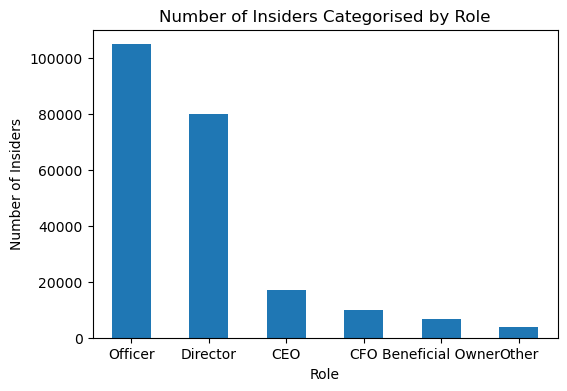

In [59]:
f, axes = plt.subplots(1, figsize = (6, 4))

ax = detail_data[['is_director', 'is_officer', 'is_ceo', 'is_cfo', 'is_beneficial_owner', 'is_other']].sum().sort_values(ascending=False).plot.bar(rot=0)
ax.set_xlabel("Role")
ax.set_ylabel("Number of Insiders")
ax.set_xticklabels(["Officer", "Director", "CEO", "CFO", "Beneficial Owner", "Other"]);
ax.set_title("Number of Insiders Categorised by Role");

As others are quite few and they are recategorised to CEO or CFO, they will not be inspected in the graphs below

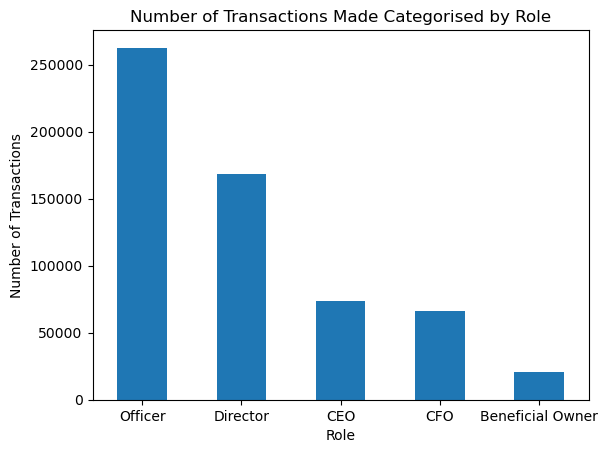

In [60]:
transaction_data = detail_data.merge(tx_data, on='accession_no')
ax = transaction_data[['is_director', 'is_officer', 'is_ceo', 'is_cfo', 'is_beneficial_owner']].sum().sort_values(ascending=False).plot.bar(rot=0)

ax.set_xlabel("Role")
ax.set_ylabel("Number of Transactions")
ax.set_xticklabels(["Officer", "Director", "CEO", "CFO", "Beneficial Owner"]);
ax.set_title("Number of Transactions Made Categorised by Role");

From the transaction type breakdown below, sale transactions (S) are the most, followed by exercise or conversion of derivative security (M), and then grant (A). Purchase transactions have lower coverage.

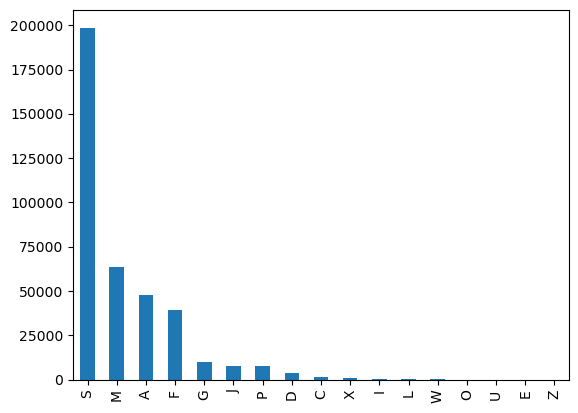

In [62]:
tx_data.code.value_counts().plot(kind = 'bar');

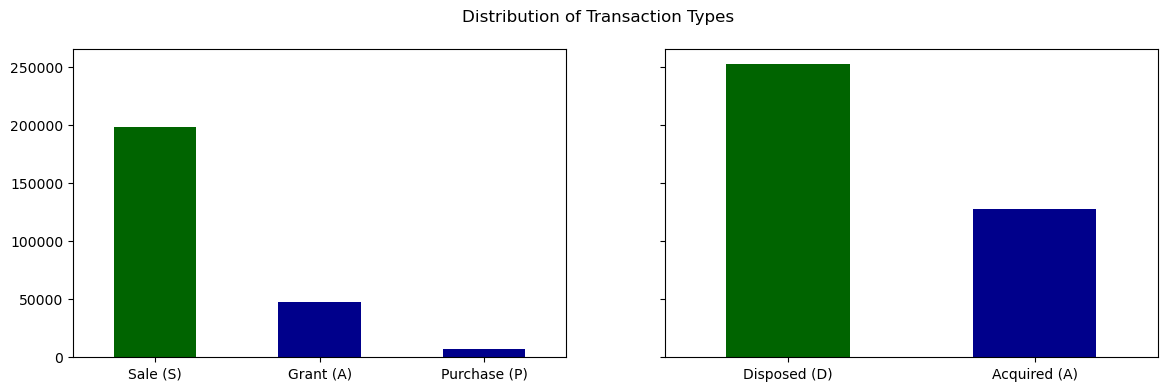

In [63]:
f, axes = plt.subplots(1, 2, figsize = (14, 4), sharey = True)

sale_buy_grant = tx_data.loc[(tx_data.code == 'S') | (tx_data.code == 'A') | (tx_data.code == 'P'), 'code']
sale_buy_grant.value_counts().plot(kind = 'bar', ax = axes[0], rot = 0, color = ['darkgreen', 'darkblue', 'darkblue'])
tx_data.acquired.value_counts().plot(kind = 'bar', ax = axes[1], rot = 0, color = ['darkgreen', 'darkblue'])

f.suptitle("Distribution of Transaction Types")
axes[0].set_xticklabels(['Sale (S)', 'Grant (A)', 'Purchase (P)'])
axes[1].set_xticklabels(['Disposed (D)', 'Acquired (A)']);

### Distribution of Number of Companies Having a Number of Insiders
Although only 150 S&P 500 companies are shown, the trend is similar to the benchmark. Fewer companies have more insiders. From the graph below, typically only one company has many insiders (from 20 to 100 insiders).

Findings: 
1. Companies typically have 35 to 70 insiders. However, less companies have more than 70 insiders. Most companies do not have just 1 or 2 insiders, possibly because these companies are listed on S&P500, and based on the company size, there should be at least 30 insiders who hold director or officer positions.

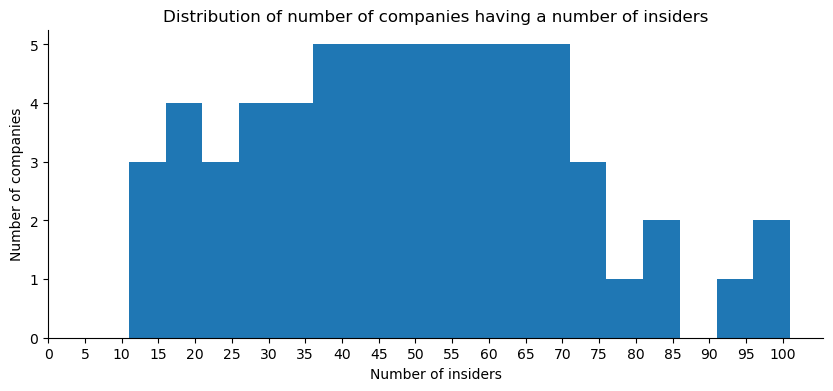

In [64]:
width = 5
tx_group = detail_data.groupby(['CIK'])['reporter_cik'].nunique()
tx_distribution = tx_group.groupby(tx_group).count()
tx = pd.Series(tx_distribution.index.values, index = tx_distribution)
fig = plt.figure(figsize=(10, 4))
ax = plt.axes()

n = math.ceil((tx.max() - tx.min())/width)
plt.hist(tx, bins = n)
ax.set_xticks(np.arange(0, tx.max(), 5))
ax.set_xlabel('Number of insiders')
ax.set_ylabel('Number of companies')
ax.set_title('Distribution of number of companies having a number of insiders')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [65]:
transaction_data = detail_data.reset_index().merge(tx_data, on='accession_no').sort_values(by = 'Date')
transaction_data.head()

,Date,Company,CIK_x,Link,trad_symbol,accession_no,form,reporter_name,reporter_cik,reporter_title,...,is_ceo,is_cfo,CIK_y,stock_type,code,acquired,shares_exchanged,net_shares_owned,stock_price,direct_ownership
0,2003-07-28,Ross Stores Inc,745732,https://www.sec.gov/Archives/edgar/data/745732...,ROST,117911003004240,4,Rentler Barbara,1238947,Senior VP,...,False,False,745732,COMMON STOCK,S,D,3500.0,62040.0,44.0000,D
14,2003-07-28,Fastenal Co,815556,https://www.sec.gov/Archives/edgar/data/815556...,FAST,117911003004229,4,Kierlin Robert A,901066,NaN,...,False,False,815556,Common Stock,X,D,20240.0,6586682.0,27.5000,D
12,2003-07-28,Williams Companies Inc,107263,https://www.sec.gov/Archives/edgar/data/107263...,WMB,120919103013969,4,Williams Companies Inc,107263,NaN,...,False,False,107263,Common Units,S,D,5100.0,2349691.0,12.1508,D
11,2003-07-28,Williams Companies Inc,107263,https://www.sec.gov/Archives/edgar/data/107263...,WMB,120919103013969,4,Williams Companies Inc,107263,NaN,...,False,False,107263,Common Units,S,D,5000.0,2354791.0,12.1000,D
10,2003-07-28,Danaher Corp De,313616,https://www.sec.gov/Archives/edgar/data/313616...,DHR,120525203000004,4,Ditkoff James H,1205252,Senior VP--Finance & Tax,...,False,False,313616,"Common stock, par value $.01 per share",D,D,10000.0,49959.0,70.5000,D


Findings
1. There are more sales than purchases, and even more grants than purchases, suggesting that companies usually compensate officers with stock grants, and there are more officers than directors.
2. Sales plunged during the economic crisis in 2008, but returned to the previous pattern from 2010 onwards. A possible explanation is that stock options are not exercised because they were compensated at-the-money before the Quant Meltdown (market collapse), hence becoming worthless to exercise.


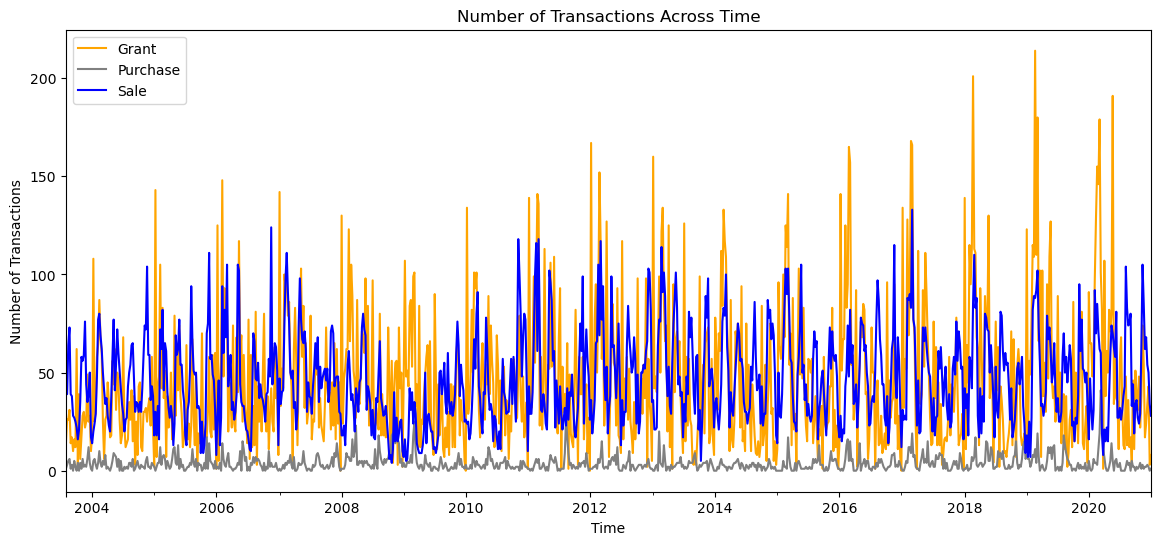

In [66]:
data = transaction_data.loc[(transaction_data.code == 'A') | (transaction_data.code == 'P') | (transaction_data.code == 'S'), ['Date', 'code', 'Company', 'reporter_cik']].drop_duplicates()
data = data.loc[:,['Date', 'code', 'Company']]
data = data.groupby(['Date', 'code']).count().unstack().fillna(0)
f, axes = plt.subplots(figsize = (14, 6))
data.resample('W').sum().plot(ax = axes, color = ['orange', 'grey', 'blue'])

# Plot configs
plt.title("Number of Transactions Across Time")
plt.ylabel("Number of Transactions")
plt.xlabel("Time")
plt.legend(["Grant", "Purchase", "Sale"]);
ax = plt.gca()
plt.savefig('Results/tx_across_time')
plt.show()

For the graph above, multiple transactions of the same type by an insider in a day are counted once. This is to eliminate the effect of insiders making multiple transactions in a day, causing the number of transactions to spike.

#### If Multiple Transactions of the Same Type by an Insider in a Day are Counted Once
As comparison, the figure below shows the graph if those transactions are counted multiple times.

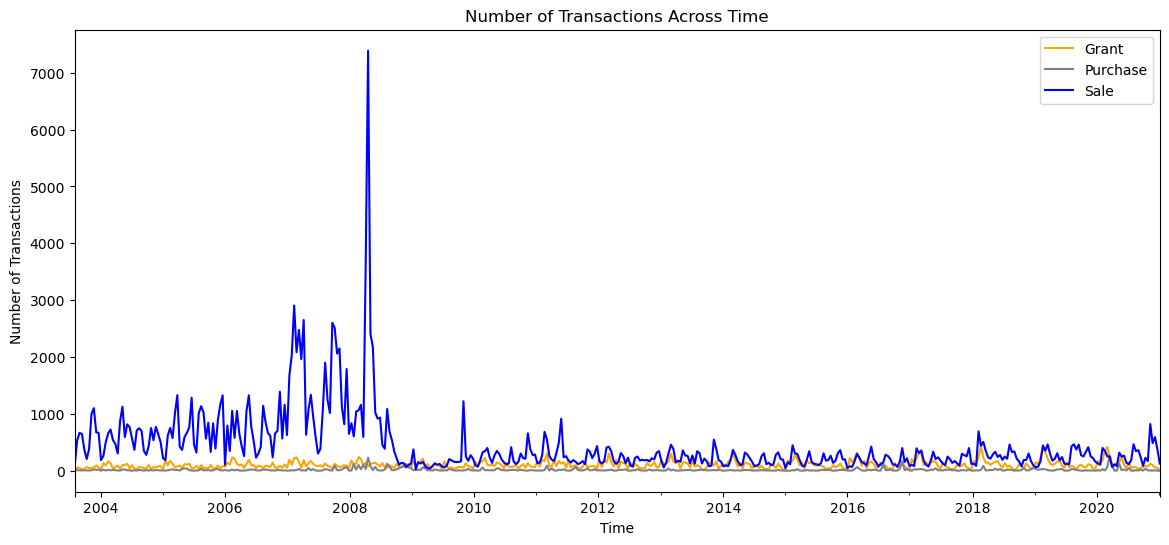

In [189]:
# To be deleted
data = transaction_data.loc[(transaction_data.code == 'A') | (transaction_data.code == 'P') | (transaction_data.code == 'S'), ['Date', 'code', 'Company']]
data = data.groupby(['Date', 'code']).count().unstack().fillna(0)
f, axes = plt.subplots(figsize = (14, 6))
data.resample('2W').sum().plot(ax = axes, color = ['orange', 'grey', 'blue'])

# Plot configs
plt.title("Number of Transactions Across Time")
plt.ylabel("Number of Transactions")
plt.xlabel("Time")
plt.legend(["Grant", "Purchase", "Sale"]);
ax = plt.gca()
plt.savefig('Results/tx_across_time_duplicated_daily_tx')
plt.show()

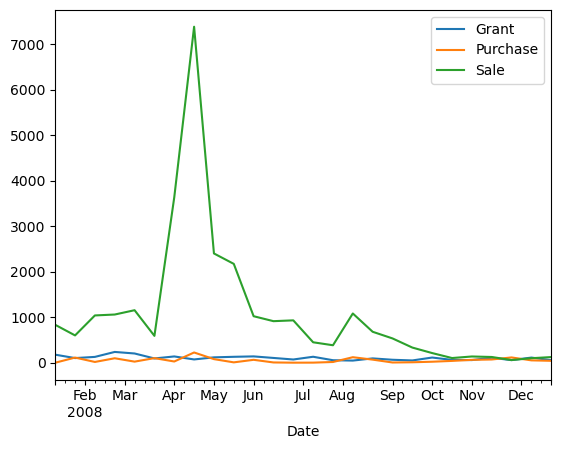

In [190]:
data.resample('2W').sum().loc['2008'].plot()
plt.legend(["Grant", "Purchase", "Sale"]);

##### Inspect Distribution
The number of transactions made in April 2008 is extremely high. Investigation is done in this section.

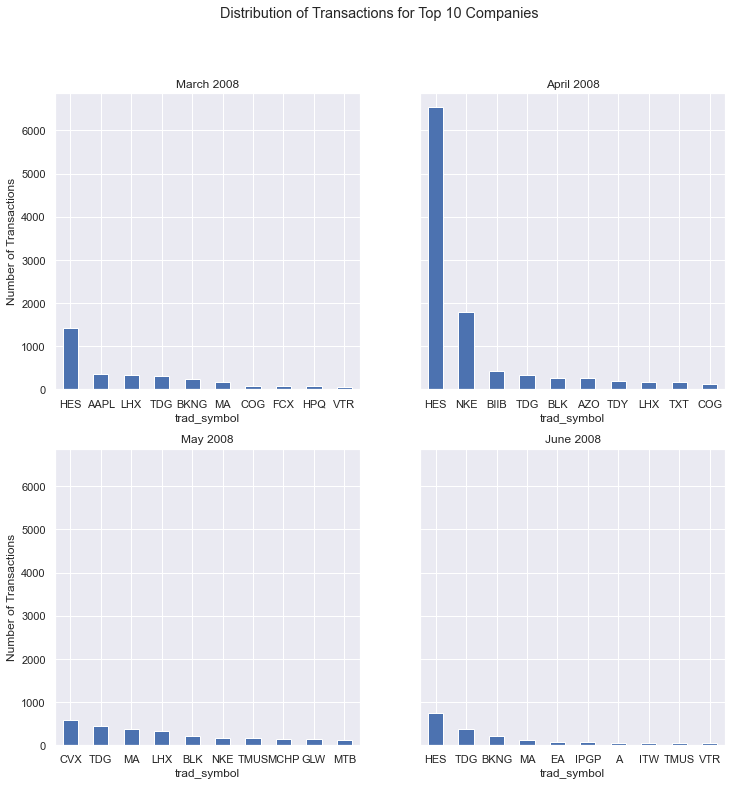

In [10]:
f, axes = plt.subplots(2, 2, figsize = (12, 12), sharey = True)
start_month, end_month = '2008-03', '2008-06'
inspect_data = transaction_data.set_index('Date')
axi = axes.ravel()
plt.suptitle("Distribution of Transactions for Top 10 Companies")
for i, period in enumerate(pd.period_range(start_month, end_month, freq = '1M')):
    data = inspect_data.loc[str(period), ['trad_symbol']].value_counts()[:10]
    data.plot.bar(ax = axi[i], rot = 0)
    axi[i].set_xticklabels([x for x, in data.index.tolist()])
    axi[i].set_title(period.strftime("%B %Y"))
    axi[i].set_ylabel('Number of Transactions')

Among the few months during the economic crisis, HES has a spike in transactions

In [192]:
print(f"HES' company name: {inspect_data[inspect_data.trad_symbol == 'HES'].Company.unique()[0]}")
hes = inspect_data.loc['2008-04']
hes = hes.loc[hes['trad_symbol'] == 'HES']
hes.reporter_name.value_counts()

HES' company name: Amerada Hess Corp


Hess John B    6540
Name: reporter_name, dtype: int64

**All transactions** in April are done by John B. Hess, then CEO of Amerada Hess Corp.

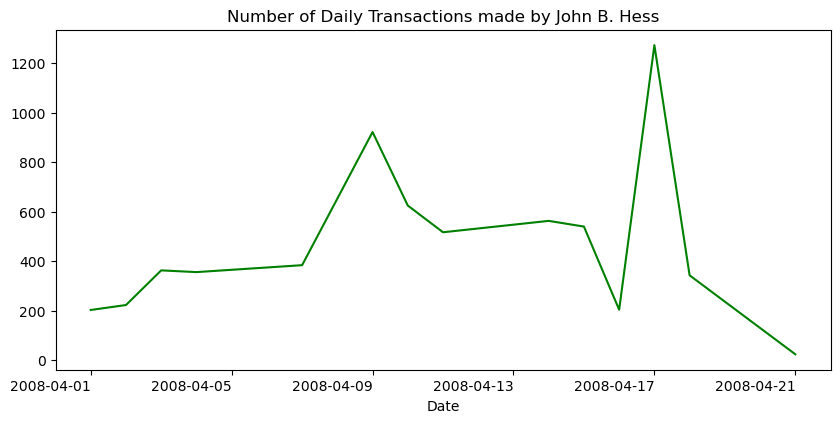

In [193]:
plt.style.use('default')
fig = plt.figure(figsize = (10, 5))
hes.groupby(hes.index).count()['Company'].plot(color = 'green', rot = 0);
plt.title('Number of Daily Transactions made by John B. Hess');

In [194]:
hes.loc['2008-04-17'].Link.value_counts().head()

https://www.sec.gov/Archives/edgar/data/4447/000120919108024678/doc4.xml    30
https://www.sec.gov/Archives/edgar/data/4447/000120919108024511/doc4.xml    30
https://www.sec.gov/Archives/edgar/data/4447/000120919108024682/doc4.xml    30
https://www.sec.gov/Archives/edgar/data/4447/000120919108024615/doc4.xml    30
https://www.sec.gov/Archives/edgar/data/4447/000120919108024518/doc4.xml    30
Name: Link, dtype: int64

A closer look at the Form 4 filings show that 
1. There are more sales than purchases
2. John B. Hess actually sold his shares at different time intervals. This causes the transaction count in April 2008 to spike in the graph above.
3. He sold them for indirect ownership
  
Key Takeaway
1. Insiders may sell the same shares at different intervals and hence have many transactions

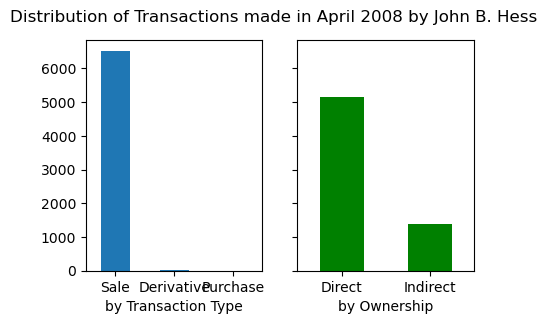

In [195]:
# Sales are the most
f, axes = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
plt.suptitle("Distribution of Transactions made in April 2008 by John B. Hess");
hes.code.value_counts().plot(kind = 'bar', figsize = (5, 3), ax = axes[0], rot = 0);
hes.direct_ownership.value_counts().plot(kind = 'bar', color = 'green', ax = axes[1], rot = 0)

axes[0].set_xticklabels(['Sale', 'Derivative', 'Purchase']);
axes[0].set_xlabel('by Transaction Type')
axes[1].set_xticklabels(['Direct', 'Indirect']);
axes[1].set_xlabel('by Ownership');

From the graph below, while 25% of the transactions are for indirect ownership, John B. Hess sold many directly owned shares. However, he sold his shares at several times a day, explaining the surge of transaction number in the graph above.

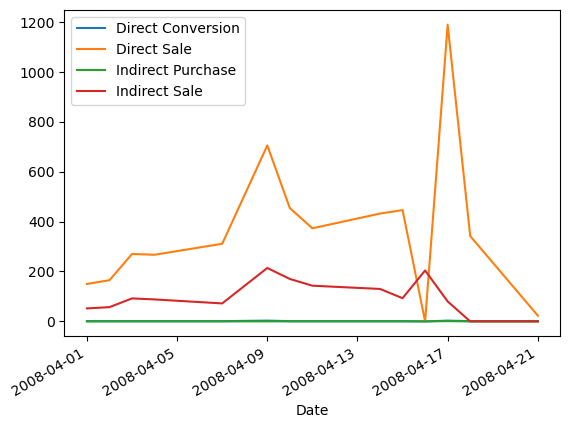

In [196]:
# 2. The transactions are done at different times of the day instead of in a single transaction
hes_dist = hes.loc[:,['code', 'Company', 'direct_ownership']].pivot_table('Company', index = hes.index, columns = ['direct_ownership', 'code'], aggfunc = 'count')
ax = hes_dist.fillna(0).plot();
ax.legend(['Direct Conversion', 'Direct Sale', 'Indirect Purchase', 'Indirect Sale'])
hes_dist;

##### Compare with Actual Trend
To obtain more insights, the stock price of HES within that period is fetched from Yahoo Finance for comparison.

In [197]:
from pandas_datareader import data
hess = data.DataReader('HES', start = '2008', end='2009', data_source='yahoo')
hess.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-12-31,103.040001,100.449997,100.449997,100.860001,3097000.0,84.633369
2008-01-02,100.489998,97.849998,100.070000,98.860001,5115300.0,82.955139
2008-01-03,101.050003,97.839996,98.900002,97.870003,4761400.0,82.124428
2008-01-04,96.349998,90.230003,96.349998,93.349998,9315100.0,78.331589
2008-01-07,95.860001,91.470001,93.739998,92.919998,5189100.0,77.970772


From the graph below, John B. Hess sold HES shares over a month in the period where HES stock price increased over the months, which then started falling in late June.  

Findings
1. While there is no evidence if Hess sold based on insider information, the practice of using data analytics by comparing transaction behaviour with stock price could help regulators monitor insider trading, and flag suspicious trading activites in the sea amount of transactions.

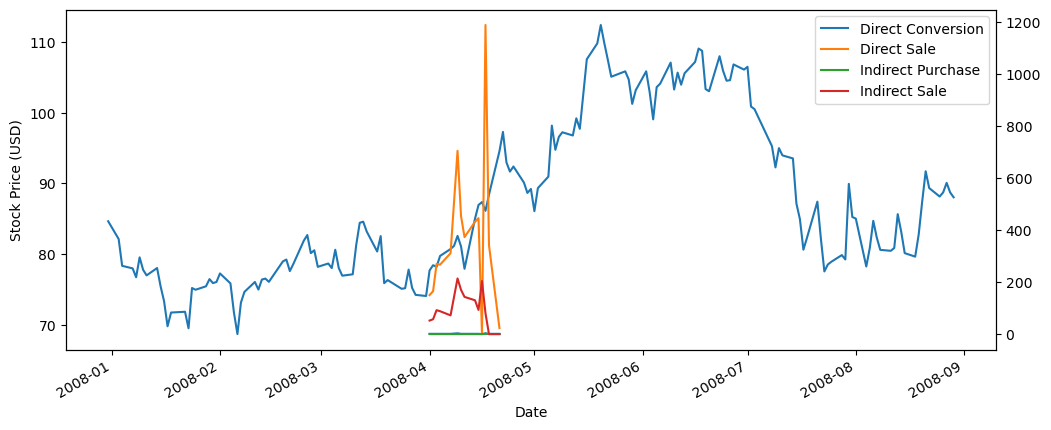

In [198]:
f, axes = plt.subplots(1, 1, figsize = (12, 5))
hess_trend = hess.loc[:'2008-08','Adj Close']
ax = hess_trend.plot()
ax.set_ylabel("Stock Price (USD)")

ax2 = ax.twinx()
hes_dist = hes.loc[:,['code', 'Company', 'direct_ownership']].pivot_table('Company', index = hes.index, columns = ['direct_ownership', 'code'], aggfunc = 'count')
hes_dist.fillna(0).plot(ax = ax2);
ax2.legend(['Direct Conversion', 'Direct Sale', 'Indirect Purchase', 'Indirect Sale'])
hes_dist;
plt.savefig('Results/tx_with_stockP')

## Time Series by Role Codes
Monthly visualisation is shown.  

Findings
1. Beneficial owners indeed have different behaviours than company insiders.. There is a spike after June 2008 (economic crisis), but the number of transactions remains low all the while compared to officers.
2. More officers' transactions than directors' transactions. This is aligned with the paper's explanation that there are more officers than directors.
3. The transactions spiked regularly. This could be interpreted as routine transaction.

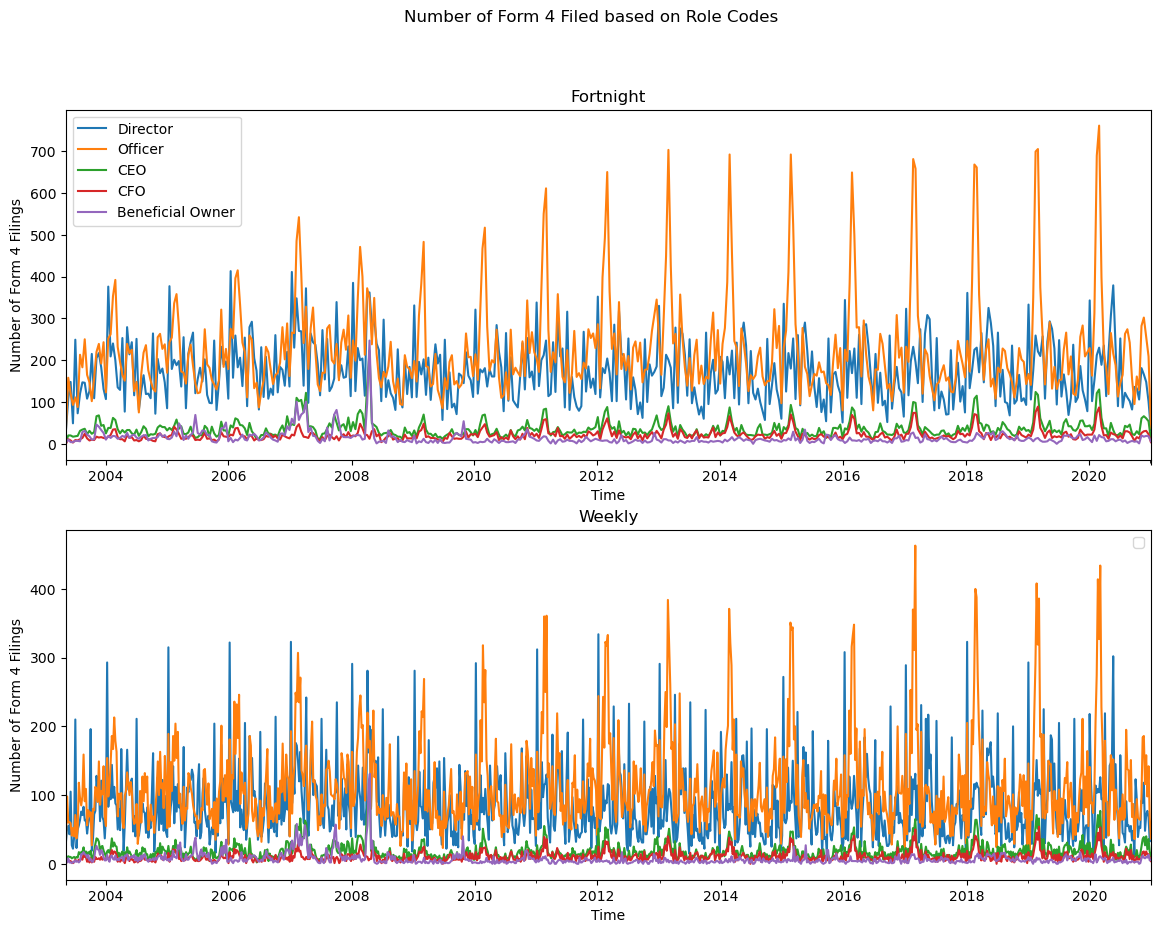

In [199]:
f, axes = plt.subplots(2, 1, figsize = (14, 10))
df_role = detail_data[['is_director', 'is_officer', 'is_ceo', 'is_cfo', 'is_beneficial_owner']]
df_role.resample('2W').sum().plot(ax = axes[0])
plt.suptitle("Number of Form 4 Filed based on Role Codes")
axes[0].set_ylabel("Number of Form 4 Filings")
axes[0].set_xlabel("Time")
axes[0].legend(["Director", "Officer", "CEO", "CFO", "Beneficial Owner"]);
axes[0].set_title('Fortnight')

df_role.resample('W').sum().plot(ax = axes[1])
axes[1].set_ylabel("Number of Form 4 Filings")
axes[1].set_xlabel("Time")
axes[1].set_title('Weekly')
axes[1].legend([])
plt.show()

##### Inspect Spikes
A simple value count shows that many Form 4 are filed in February and March, producing the spikes.

In [200]:
df_officer = df_role.is_officer.resample('2W').sum()
df_officer = df_officer[df_officer > 350]
df_officer.index.strftime("%m").value_counts()

02    25
03    21
05     2
04     1
Name: Date, dtype: int64

In [201]:
detail_data['Month'] = detail_data.index.strftime("%m").to_numpy(dtype = 'int')

In [202]:
detail_data[(detail_data.Month == 2) | (detail_data.Month == 3)].Company.nunique()

149

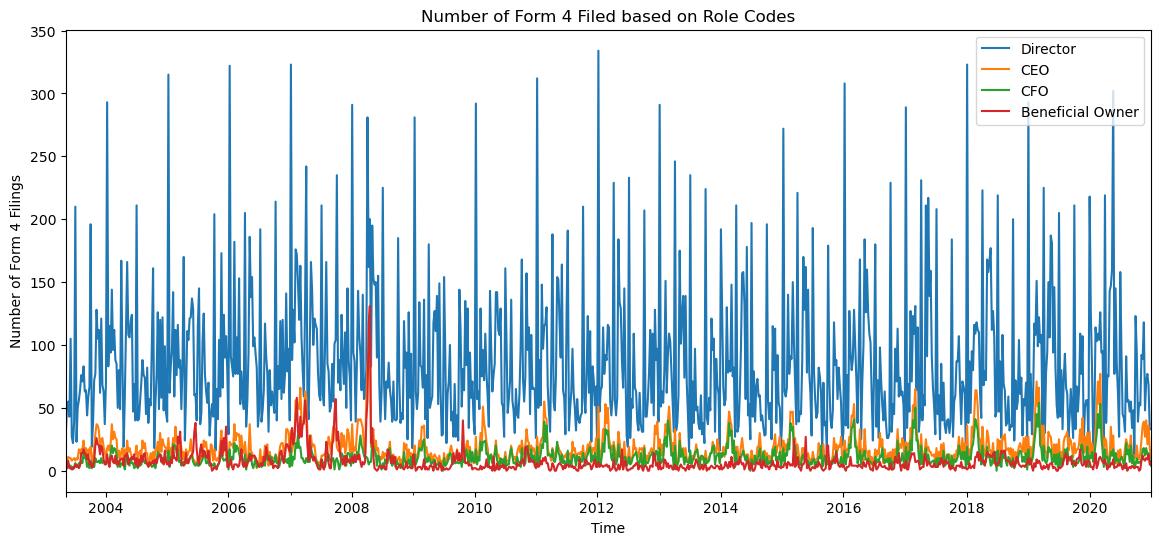

In [203]:
f, axes = plt.subplots(figsize = (14, 6))
df_role = detail_data[['is_director', 'is_ceo', 'is_cfo', 'is_beneficial_owner']]
df_role.resample('W').sum().plot(ax = axes)
plt.title("Number of Form 4 Filed based on Role Codes")
plt.ylabel("Number of Form 4 Filings")
plt.xlabel("Time")
plt.legend(["Director", "CEO", "CFO", "Beneficial Owner"]);
ax = plt.gca()
plt.savefig('Results/form4_by_role')
plt.show()

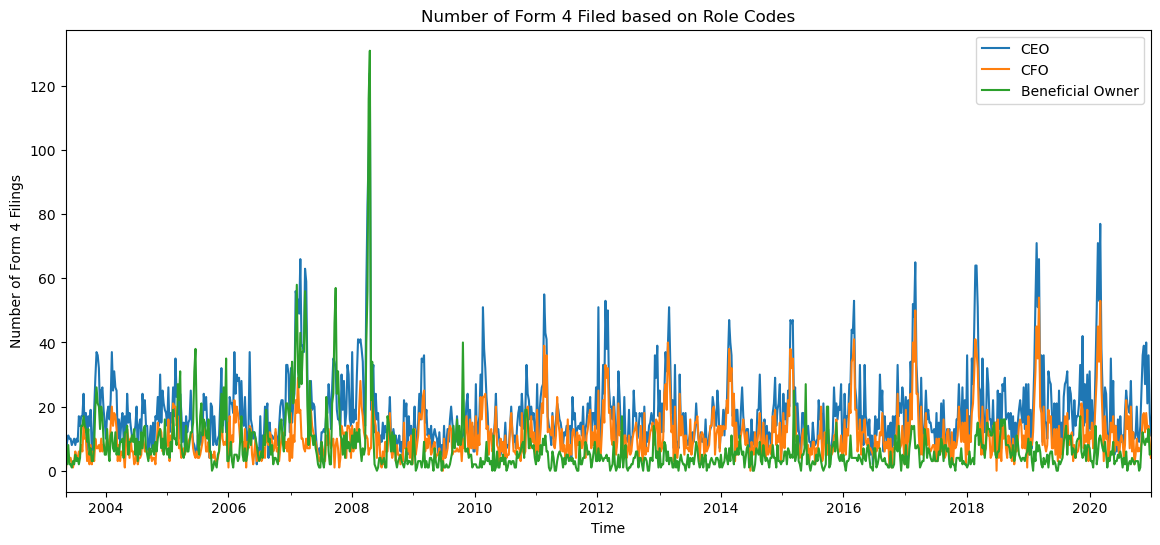

In [204]:
f, axes = plt.subplots(figsize = (14, 6))
df_role = detail_data[['is_ceo', 'is_cfo', 'is_beneficial_owner']]
df_role.resample('W').sum().plot(ax = axes)
plt.title("Number of Form 4 Filed based on Role Codes")
plt.ylabel("Number of Form 4 Filings")
plt.xlabel("Time")
plt.legend(["CEO", "CFO", "Beneficial Owner"]);
ax = plt.gca()
plt.savefig('Results/form4_by_ceo_cfo_ben')
plt.show()

<AxesSubplot:>

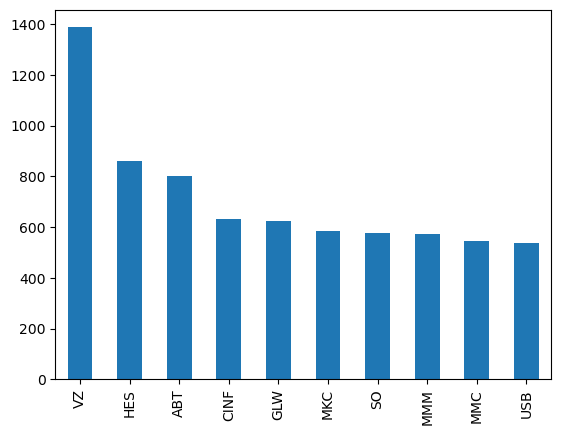

In [205]:
detail_data[(detail_data.Month == 2) | (detail_data.Month == 3)].trad_symbol.value_counts()[:10].plot(kind = 'bar')

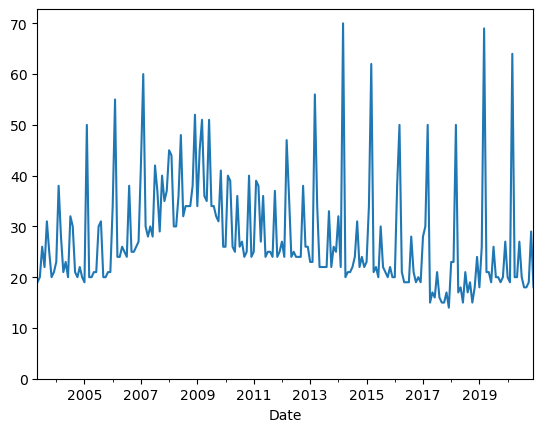

In [206]:
plt.style.use('default')
ax = detail_data.loc[detail_data.trad_symbol == 'VZ'].resample('M').count().Company.plot();
ax.set_ylim(ymin=0);

In [207]:
vz_data = detail_data.loc[detail_data.trad_symbol == 'VZ'].resample('M').count().Company
vz_spike = vz_data[vz_data > 45]
vz_spike.index

DatetimeIndex(['2005-02-28', '2006-02-28', '2007-02-28', '2008-06-30',
               '2008-12-31', '2009-03-31', '2009-06-30', '2012-03-31',
               '2013-03-31', '2014-03-31', '2015-03-31', '2016-03-31',
               '2017-03-31', '2018-03-31', '2019-03-31', '2020-03-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [208]:
vz_full_data = detail_data[(detail_data.trad_symbol == 'VZ') & ((detail_data.Month == 2) | (detail_data.Month == 3))]
# vz_full_data.reporter_name.value_counts()[:10]
vz_reporter = vz_full_data.groupby([vz_full_data.index.year, vz_full_data.index.month]).reporter_cik.value_counts().unstack()
vz_reporter.head()

reporter_cik  905129   1017080  1018572  1018796  1055697  1055707  1174642  \
Date Date                                                                     
2004 2            1.0      NaN      NaN      4.0      1.0      NaN      1.0   
     3            NaN      NaN      NaN      4.0      NaN      1.0      NaN   
2005 2            1.0      NaN      NaN      4.0      1.0      1.0      1.0   
     3            NaN      NaN      NaN      2.0      NaN      NaN      NaN   
2006 2            1.0      NaN      1.0      4.0      1.0      1.0      1.0   

reporter_cik  1184648  1187725  1187727  ...  1629703  1651274  1656598  \
Date Date                                ...                              
2004 2            1.0      1.0      3.0  ...      NaN      NaN      NaN   
     3            NaN      NaN      3.0  ...      NaN      NaN      NaN   
2005 2            NaN      1.0      4.0  ...      NaN      NaN      NaN   
     3            NaN      NaN      2.0  ...      NaN      NaN      NaN   
2006 2            NaN      1.0      3.0  ...      NaN      NaN      NaN   

reporter_cik  1686326  1702684  1748263  1753912  1760581  1760658  1774942  
Date Date                                                                    
2004 2            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
     3            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
2005 2            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
     3            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
2006 2            NaN      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 67 columns]

##### Inspection Done

<AxesSubplot:xlabel='Date'>

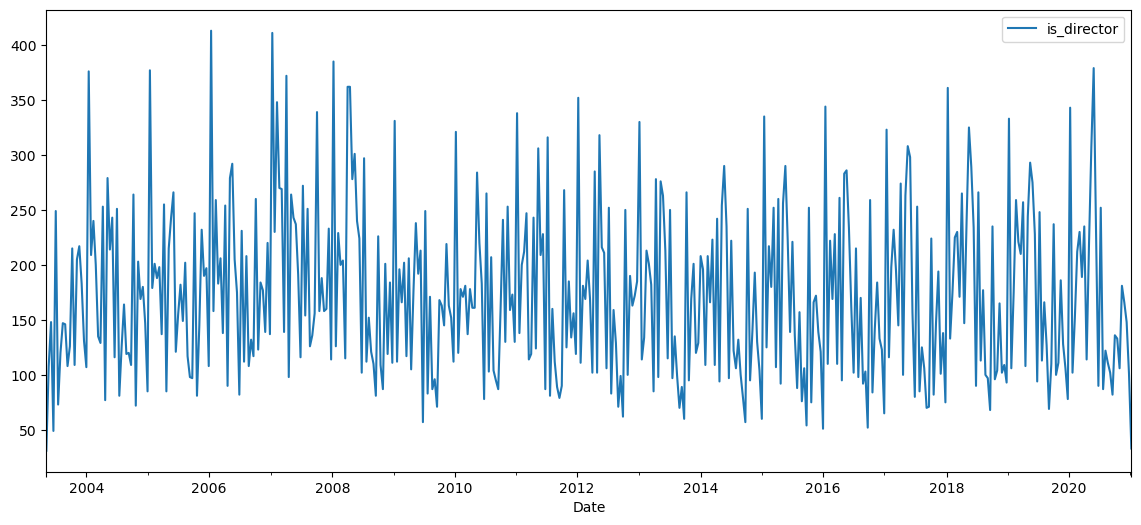

In [209]:
# Plotting directors' Form 4 files filed
f, axes = plt.subplots(1, 1, figsize = (14, 6))
df_director = detail_data[['is_director']]
df_director.resample('2W').sum().plot(ax = axes)

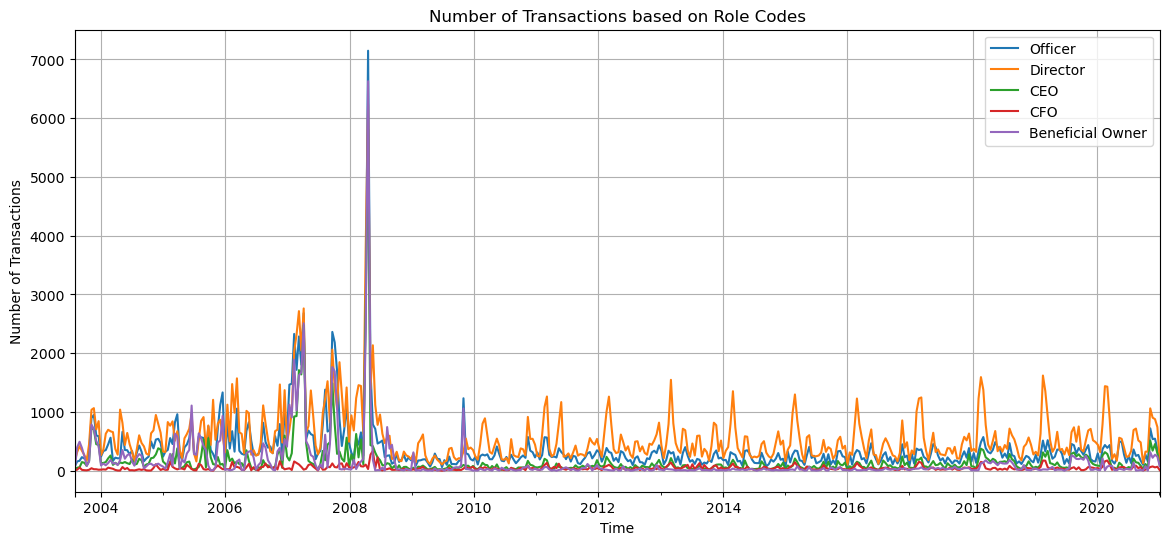

In [210]:
# Plot the number of transactions based on role codes
transaction_data = detail_data.reset_index().merge(tx_data, on='accession_no').set_index('Date')
df_role = transaction_data[['is_director', 'is_officer', 'is_ceo', 'is_cfo', 'is_beneficial_owner']]
f, axes = plt.subplots(figsize = (14, 6))
df_role.resample('2W').sum().plot(ax = axes)
plt.title("Number of Transactions based on Role Codes")
plt.ylabel("Number of Transactions")
plt.xlabel("Time")
plt.legend(["Officer", "Director", "CEO", "CFO", "Beneficial Owner"]);
ax = plt.gca()
plt.grid()
plt.show()

#### Purchase after Purchase, Sale after Sale

In [211]:
transaction_data = detail_data.reset_index().merge(tx_data, on='accession_no').sort_values(by = 'Date')
transaction_data = transaction_data.loc[(transaction_data.code == 'P') | (transaction_data.code == 'S'), :]

In [212]:
tx_after_tx = pd.DataFrame(columns = ['Day', 'tx_tx'])
for reporter, group in transaction_data.groupby('reporter_cik'):
    record = []
    dt = None
    tx_type_now = set()
    for index, row in group.iterrows():
        for prev in tx_type_now:
            record.append([pd.to_timedelta(row.Date - dt).days, prev + '-' + row.code])
        
        if dt != None and pd.to_timedelta(row.Date - dt).days == 0:
            tx_type_now.add(row.code)
        else:
            tx_type_now = set(row.code)
        dt = row.Date
        
    record = pd.DataFrame(record, columns = ['Day', 'tx_tx'])
    tx_after_tx = pd.concat([tx_after_tx, record], axis = 0, ignore_index = True)

In [213]:
print(f"Min: {tx_after_tx.Day.min()}\nMedian: {tx_after_tx.Day.median()}\n\
Max: {tx_after_tx.Day.max()}\n\
Mean: {tx_after_tx.Day.mean()}\n\
Standard Deviation: {tx_after_tx.Day.std()}\n\
Threshold for Outlier: {tx_after_tx.Day.mean() + 3*tx_after_tx.Day.std()}")

Min: 0
Median: 0.0
Max: 5702
Mean: 37.23554430528779
Standard Deviation: 167.9702802794348
Threshold for Outlier: 541.1463851435922


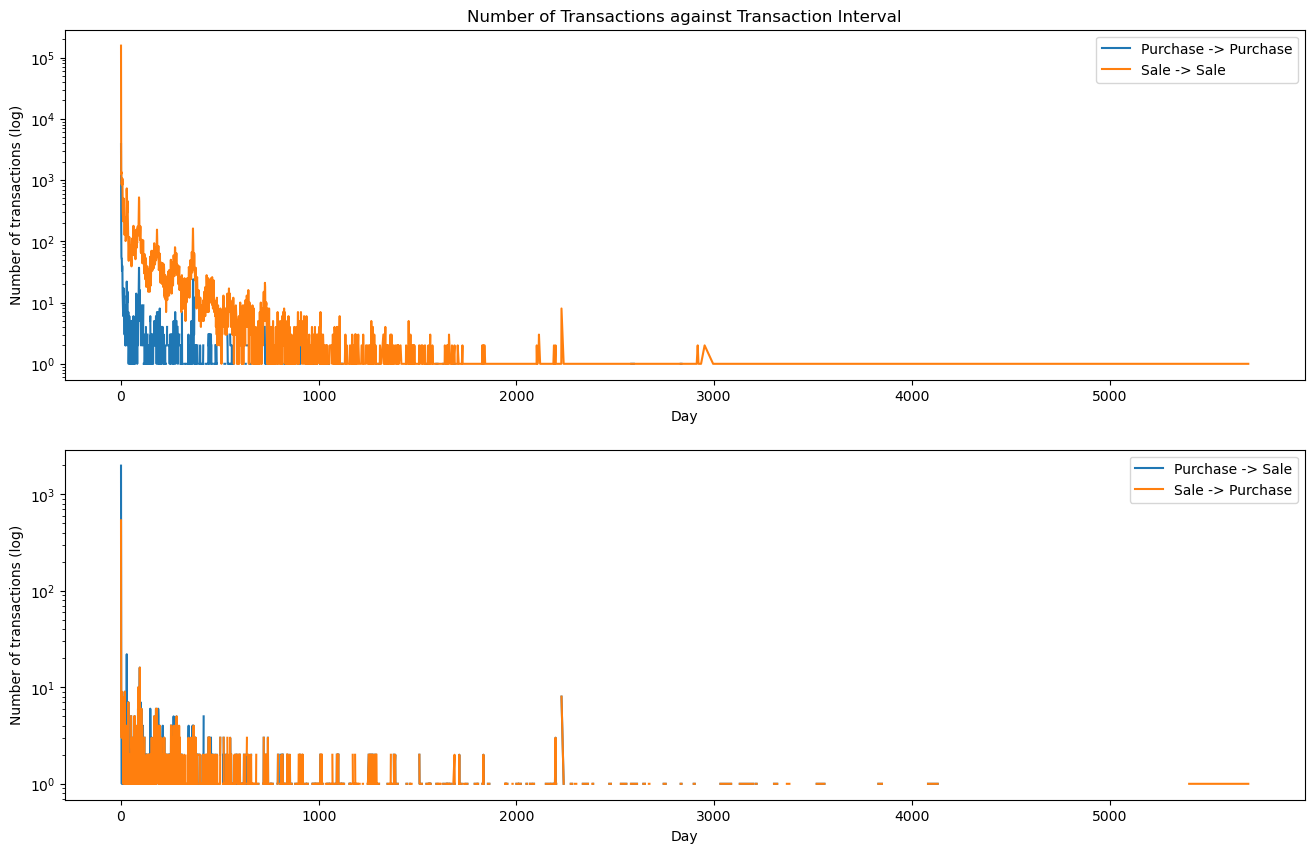

In [214]:
# Plot graphs over the maximum number of days possible
transactions = tx_after_tx.groupby('tx_tx')['Day'].value_counts().unstack().fillna(method = 'ffill').T
f, axes = plt.subplots(2, 1, figsize = (16, 10))
transactions[['P-P', 'S-S']].plot(ax = axes[0])
transactions[['P-S', 'S-P']].plot(ax = axes[1])
axes[0].set_title('Number of Transactions against Transaction Interval');
axes[0].set_yscale('log')
axes[0].set_ylabel('Number of transactions (log)');
axes[0].legend(['Purchase -> Purchase', 'Sale -> Sale'])
axes[1].set_yscale('log')
axes[1].set_ylabel('Number of transactions (log)');
axes[1].legend(['Purchase -> Sale', 'Sale -> Purchase'])

From the graph, the transactions are skewed heavily to the right. Based on the standard deviation, 
data points larger than $\mu+3\sigma$, 541 days are outliers.  

Additionally, there are only a few transactions that have a gap of more than 1000 days (at least 4 years). There should be no relationship between two transactions with 5-year hiatus.   

To compare with the reference paper, gap days that are less than 1000 days are inspected

Findings
1. P->P and S->S follow an oscillatory pattern with 90-day cycle, indicating the influence of blackout periods. These traders, however, are regarded as routine traders and carry no insider information in their trades.
2. P->S and S->P follow an oscillatory pattern of 6-month cycle (2 cycles in 180 days) as insiders must disgorge any profits earned through a mix of both transaction types within 6 months, under the Short-Swing Profit Rule.

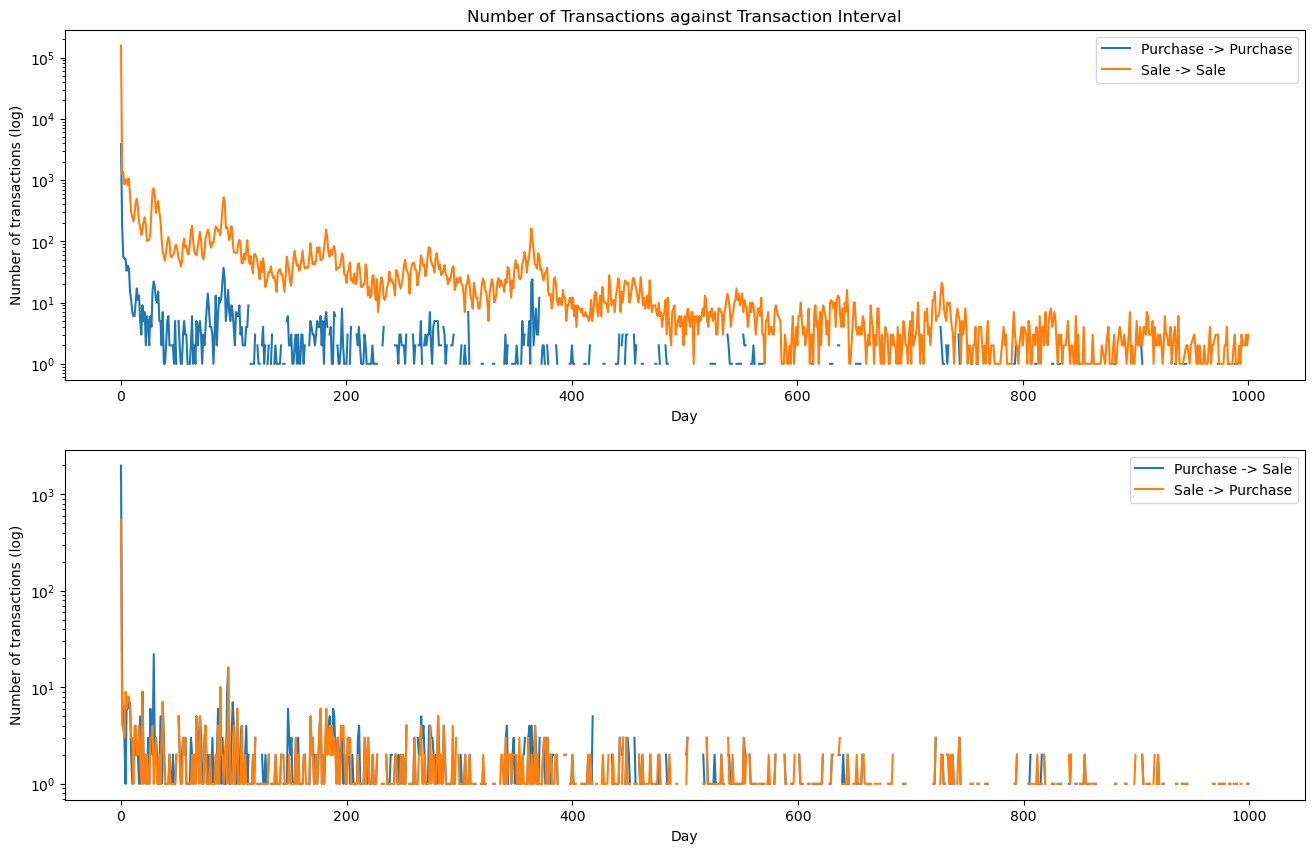

In [215]:
# Plot graphs up to 1000-day range
tx_1500_days_span = tx_after_tx[tx_after_tx.Day <= 1000]
transactions = tx_1500_days_span.groupby('tx_tx')['Day'].value_counts().unstack().fillna(method = 'ffill').T
f, axes = plt.subplots(2, 1, figsize = (16, 10))
transactions[['P-P', 'S-S']].plot(ax = axes[0])
transactions[['P-S', 'S-P']].plot(ax = axes[1])
axes[0].set_title('Number of Transactions against Transaction Interval');
axes[0].set_yscale('log')
axes[0].set_ylabel('Number of transactions (log)');
axes[0].legend(['Purchase -> Purchase', 'Sale -> Sale'])
axes[1].set_yscale('log')
axes[1].set_ylabel('Number of transactions (log)');
axes[1].legend(['Purchase -> Sale', 'Sale -> Purchase'])
plt.savefig('Results/tx_purchase_sale')

#### Transaction Interval by Role Codes
Findings
1. Officers and directors have more sales than purchases, suggesting that they are given stock grants as compensation.
2. Officers are rewarded with more stocks than directors.
3. Officers and directors have oscillatory pattern of 90 days, suggesting blackout window period imposed by their companies.
4. Beneficial owners do not have oscillatory pattern, suggesting that they do not have access to insider information.

In [216]:
transaction_data = detail_data.reset_index().merge(tx_data, on='accession_no').sort_values(by = 'Date')
transaction_data = transaction_data.loc[(transaction_data.code == 'P') | (transaction_data.code == 'S'), :]
transaction_data.head()

,Date,Company,CIK_x,Link,trad_symbol,accession_no,form,reporter_name,reporter_cik,reporter_title,...,is_cfo,Month,CIK_y,stock_type,code,acquired,shares_exchanged,net_shares_owned,stock_price,direct_ownership
0,2003-07-28,Ross Stores Inc,745732,https://www.sec.gov/Archives/edgar/data/745732...,ROST,117911003004240,4,Rentler Barbara,1238947,Senior VP,...,False,7,745732,COMMON STOCK,S,D,3500.0,62040.0,44.0000,D
12,2003-07-28,Williams Companies Inc,107263,https://www.sec.gov/Archives/edgar/data/107263...,WMB,120919103013969,4,Williams Companies Inc,107263,NaN,...,False,7,107263,Common Units,S,D,5100.0,2349691.0,12.1508,D
11,2003-07-28,Williams Companies Inc,107263,https://www.sec.gov/Archives/edgar/data/107263...,WMB,120919103013969,4,Williams Companies Inc,107263,NaN,...,False,7,107263,Common Units,S,D,5000.0,2354791.0,12.1000,D
5,2003-07-28,Nvr Inc,906163,https://www.sec.gov/Archives/edgar/data/906163...,NVR,90616303000016,4,Schar Dwight C,1212710,Chairman of the Board and CEO,...,False,7,906163,"NVR, Inc. common stock",S,D,40300.0,741798.0,397.0670,D
4,2003-07-28,Nvr Inc,906163,https://www.sec.gov/Archives/edgar/data/906163...,NVR,90616303000016,4,Schar Dwight C,1212710,Chairman of the Board and CEO,...,False,7,906163,"NVR, Inc. common stock",S,D,10000.0,782098.0,406.5692,D


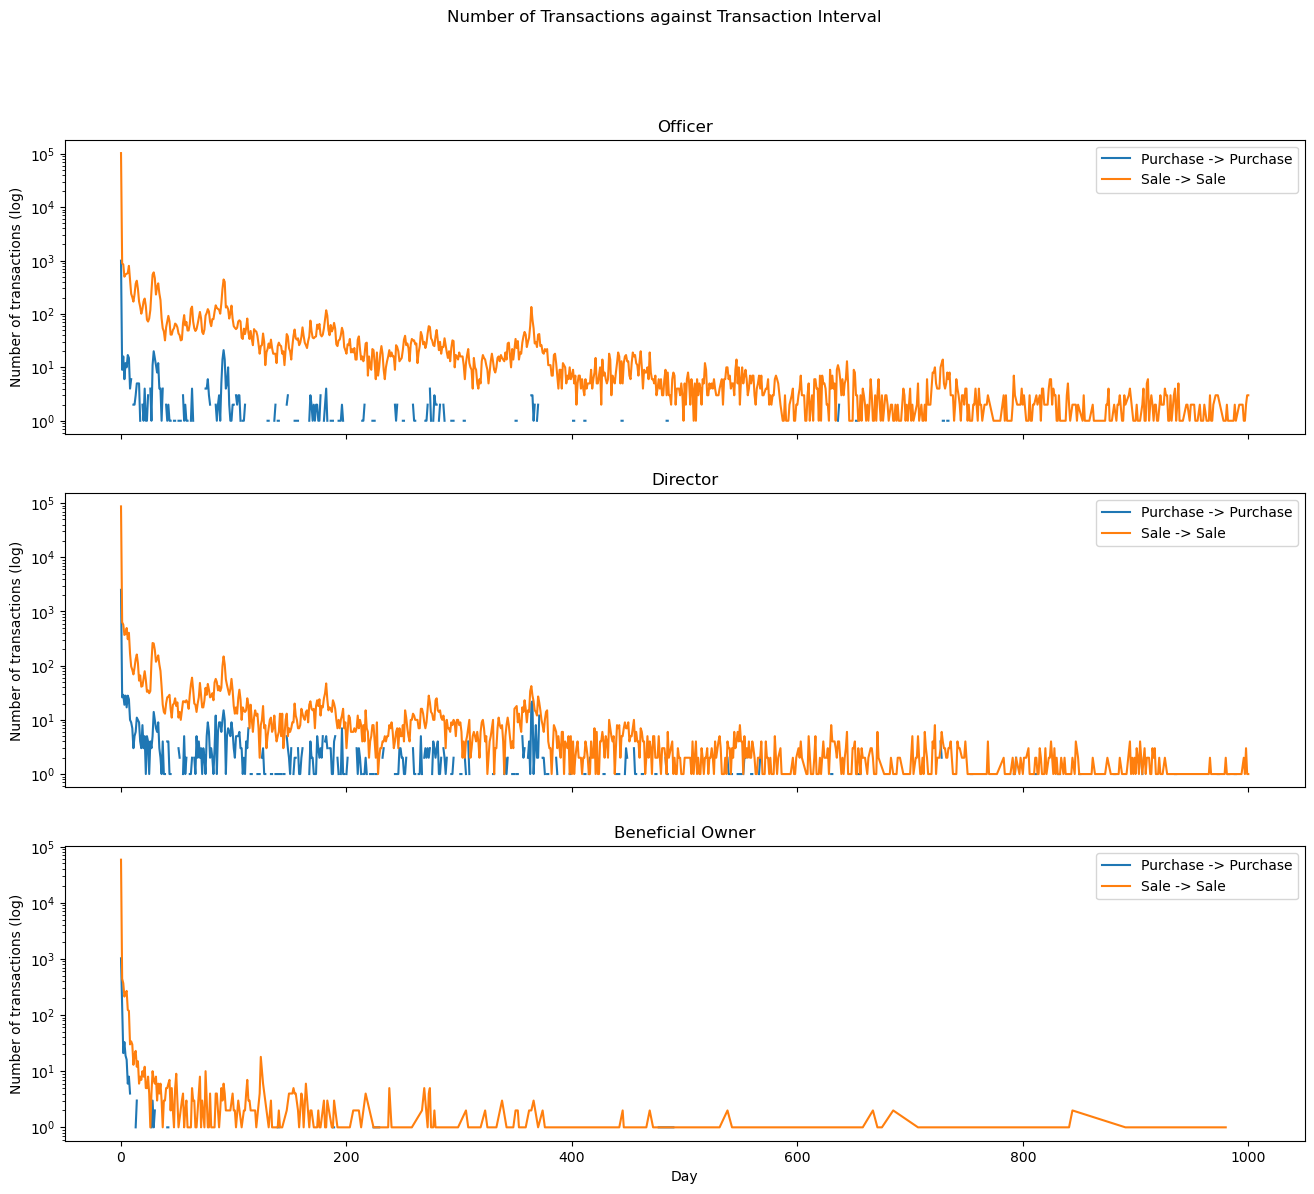

In [217]:
dimensions = ['is_officer', 'is_director', 'is_beneficial_owner']
f, axes = plt.subplots(3, 1, figsize = (16, 13), sharex = True)
f.suptitle('Number of Transactions against Transaction Interval');
for i, role in enumerate(dimensions):
    tx_after_tx = pd.DataFrame(columns = ['Day', 'tx_tx'])
    data = transaction_data[transaction_data[role] == True]
    for reporter, group in data.groupby('reporter_cik'):
        record = []
        dt = None
        tx_type_now = set()
        for index, row in group.iterrows():
            for prev in tx_type_now:
                record.append([pd.to_timedelta(row.Date - dt).days, prev + '-' + row.code])

            if dt != None and pd.to_timedelta(row.Date - dt).days == 0:
                tx_type_now.add(row.code)
            else:
                tx_type_now = set(row.code)
            dt = row.Date

        record = pd.DataFrame(record, columns = ['Day', 'tx_tx'])
        tx_after_tx = pd.concat([tx_after_tx, record], axis = 0, ignore_index = True)
    
    # plot graphs
    tx_1500_days_span = tx_after_tx[tx_after_tx.Day <= 1000]
    transactions = tx_1500_days_span.groupby('tx_tx')['Day'].value_counts().unstack().fillna(method = 'ffill').T
    transactions[['P-P', 'S-S']].plot(ax = axes[i])
    axes[i].set_yscale('log')
    axes[i].set_ylabel('Number of transactions (log)');
    axes[i].legend(['Purchase -> Purchase', 'Sale -> Sale'])
    
    if role == 'is_officer':
        axes[i].set_title('Officer')
    elif role == 'is_director':
        axes[i].set_title('Director')
    else:
        axes[i].set_title('Beneficial Owner')
    plt.savefig('Results/temporal_by_role')

## Network Centric Analysis

In [218]:
detail_data = pd.read_csv(FORM4_DETAIL_CLEAN, sep='|', parse_dates = ['Date'], index_col = 'Date')
tx_data = pd.read_csv(FORM4_TX_CLEAN, sep = '|', parse_dates = ['date'], index_col = 'date')

### Building Sale and Purchase Network

The general flow of the algorithm is as follows for each company:
> For every pair of insiders, compare the similarity index of their unique transaction dates. The insiders are added into the graph as nodes if their similarity index exceed a threshold $h_{similarity}$, and their connection is added as an edge. 

There are some parameters that should be tweaked:
- This network only constructs networks within the company: the algorithm operates on each company.
- Some insiders may have very few transaction dates. Hence, their transaction dates are too few to justify their network with another insider. A threshold, $h_{transaction}$ is needed.
- The similarity index calculation will affect who will be included into the network. This research replicates the reference paper by matching the similarity between two insiders when most of their transaction dates match. However, future studies could study more accurate calculations of the similarity index


In [219]:
unique_company_list = detail_data.Company.unique()
company_insider_list = detail_data.groupby(['Company']).apply(lambda group: group.reporter_cik.unique().tolist())
transaction_data = detail_data.reset_index().merge(tx_data, on='accession_no').sort_values(by = 'Date').set_index('Date')
company_insider_list.head()

Company
3M Co                       [1182060, 1122788, 1193998, 1193522, 1192904, ...
Abbott Laboratories         [1242826, 1190304, 1232973, 1239421, 1239420, ...
Advance Auto Parts Inc      [1052506, 1236877, 1236888, 1236884, 1074932, ...
Agilent Technologies Inc    [1168405, 1142618, 1226464, 1142615, 1142623, ...
Akamai Technologies Inc     [1035440, 1187042, 1180138, 1187046, 1192761, ...
dtype: object

In [47]:
# Constants
thres_tx_count = 5              # To avoid insiders with only few transactions from affecting the results
thres_similarity = 0.5          # Insiders are considered connected if they trade similarly (exceed the threshold)

# Similarity Index
def similarity(tx_set1, tx_set2):
    numerator = 0
    for i in range(len(tx_set1)):
        tx = tx_set1[i]
        for j in range(len(tx_set2)):
            tx2 = tx_set2[j]
            if abs((tx - tx2)).days == 0:
                numerator+=1
                break
    numerator = numerator*numerator
    similarity_index = numerator/len(tx_set1)/len(tx_set2)
    return similarity_index

# Build a network for a company
def build_network(unique_company_list, company, code):
    Gprime = nx.Graph()
    N, E = set(), set()
    unique_insider_list = company_insider_list[company]
    record = []
    for insider in unique_insider_list:
        unique_tx_data = transaction_data.loc[(transaction_data.reporter_cik == insider) & (transaction_data.Company == company) & (transaction_data.code == code)].index.unique().sort_values().tolist()
        record.append([insider, unique_tx_data])
    tx_dates = pd.DataFrame(record, columns = ['insider', 'transaction_date'])
    
    for i in range(len(unique_insider_list) - 1):
        for j in range(i+1, len(unique_insider_list)):
            insider1, insider2 = unique_insider_list[i], unique_insider_list[j]
            tx_set1, tx_set2 = tx_dates.loc[tx_dates.insider == insider1, 'transaction_date'].squeeze(), tx_dates.loc[tx_dates.insider == insider2, 'transaction_date'].squeeze()
            if len(tx_set1) >= thres_tx_count and len(tx_set2) >= thres_tx_count:
                if similarity(tx_set1, tx_set2) >= thres_similarity:
                    N.update({insider1, insider2})
                    if insider1 < insider2:
                        E.add((insider1, insider2))
                    else:
                        E.add((insider2, insider1))
            
    with open(LOG_NETWORK, 'a') as f:
        f.write(f"{company}|{code}|{len(N)}\n")
    if len(N) > 1:
        Gprime.add_nodes_from(N)
        Gprime.add_edges_from(E)
        
    return Gprime

# Build Sale or Purchase Network
def build_sale_purchase_network(unique_company_list):
    sale_graph = nx.Graph()
    purchase_graph = nx.Graph()
    for company in unique_company_list:
        company_sale_node = build_network(unique_company_list, company, 'S')
        company_purchase_node = build_network(unique_company_list, company, 'P')

        if company_sale_node.number_of_nodes() >= 1:
            sale_graph.add_node(company_sale_node, firm = company)

        if company_purchase_node.number_of_nodes() >= 1:
            purchase_graph.add_node(company_purchase_node, firm = company)
        
    return sale_graph, purchase_graph

# 15 processes of building Sale or Purchase Network are run in parallel and saved separately
# After saving them, the 15 Sale/ Purchase networks are combined into one Sale and one Purchase network
def full_network(sale_purchase):
    G = nx.Graph()
    for i in range(15):
        graph_link = BASE_DRIVE_LINK + 'Database/graph_' + sale_purchase + str(i) + '.txt'
        graph = pickle.load(open(graph_link, 'rb'))
        for company_network in graph.nodes:
            G.add_node(company_network)
        os.remove(graph_link)
    graph_link = BASE_DRIVE_LINK + 'Database/graph_' + sale_purchase + '.txt'
    pickle.dump(G, open(graph_link, 'wb'))
    return G

if __name__ == '__main__':
    with open(LOG_NETWORK, 'a') as f:
        f.write(f"Company|Sale_Purchase|Insider\n")
    with Pool(15) as p:
        sale_graphs, purchase_graphs = zip(*p.map(build_sale_purchase_network, np.split(unique_company_list, 15)))
        for i in range(len(sale_graphs)):
            graph_link = BASE_DRIVE_LINK + 'Database/graph_sale' + str(i) + '.txt'
            pickle.dump(sale_graphs[i], open(graph_link, 'wb'))
        for i in range(len(purchase_graphs)):
            graph_link = BASE_DRIVE_LINK + 'Database/graph_purchase' + str(i) + '.txt'
            pickle.dump(purchase_graphs[i], open(graph_link, 'wb'))
    G_sale = full_network('sale')
    G_purchase = full_network('purchase')

### Analysing Sale and Purchase Network

In [2]:
# Read in data for sale and purchase graphs
G_sale = pickle.load(open(BASE_DRIVE_LINK + 'Database/graph_sale.txt', 'rb'))
G_purchase = pickle.load(open(BASE_DRIVE_LINK + 'Database/graph_purchase.txt', 'rb'))

In [139]:
# Graph drawing parameters
options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}

# Function to provide summary statistics
def graph_info(G):
    num_connections = 0
    num_connected_components = 0
    insider_list = set()
    connected_components = []
    clustering_coefficients = []
    for firm in G:
        num_connected_components+=nx.number_connected_components(firm)
        insider_list.update(firm.nodes())
        num_connections+=firm.number_of_edges()
        for subnet in nx.connected_components(firm):
            connected_components.append(len(subnet))
        clustering_coef = np.array(list(nx.clustering(firm).values())).mean()
        clustering_coefficients.append(clustering_coef)
    
    print(f"Number of companies with networks: {G.number_of_nodes()}")
    print(f"Number of connected components: {num_connected_components}")
    print(f"Number of insiders involved: {len(insider_list)}")
    print(f"Number of connections: {num_connections}\n")
    return connected_components, pd.Series(clustering_coefficients, name = 'cluster')
    
print("For sale network")
connected_sale, cluster_sale = graph_info(G_sale)
print("For purchase network")
connected_purchase, cluster_purchase = graph_info(G_purchase)

For sale network
Number of companies with networks: 18
Number of connected components: 20
Number of insiders involved: 56
Number of connections: 64

For purchase network
Number of companies with networks: 3
Number of connected components: 3
Number of insiders involved: 12
Number of connections: 25



Summary Statistics of Sale and Purchase Networks

Network | Nodes | Edges | Connected Components
:--|---|---|---
Sale|56|64|20
Purchase|12|25|3

In [116]:
# Do a value count of the clusters by their clustering coefficients
cluster_sale_count = cluster_sale.value_counts()
cluster_sale_count[cluster_sale_count.index > 0.5]

1.000000    2
0.600000    1
0.533333    1
Name: cluster, dtype: int64

From the value counts above, there are two complete graphs. These indicates that the network is tight.
Let us draw these graphs.

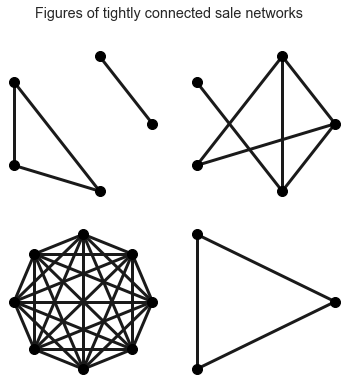

In [143]:
f, axes = plt.subplots(2, 2, figsize = (6, 6))
plt.suptitle("Figures of tightly connected sale networks")
axi = axes.ravel()
ax_counter = 0
for firm in G_sale:
    clustering_coef = np.array(list(nx.clustering(firm).values())).mean()
    if clustering_coef > 0.5:
        nx.draw_circular(firm, ax = axi[ax_counter], **options)
        ax_counter+=1
plt.savefig('Results/sale_network')

In [137]:
cluster_purchase_count = cluster_purchase.value_counts()
cluster_purchase_count[cluster_purchase_count.index > 0.5]

0.890476    1
Name: cluster, dtype: int64

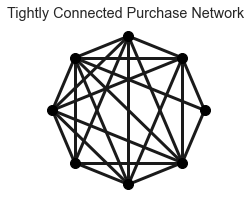

In [144]:
f, axes = plt.subplots(1, 1, figsize = (3, 3))
plt.suptitle("Tightly Connected Purchase Network")
for firm in G_purchase:
    clustering_coef = np.array(list(nx.clustering(firm).values())).mean()
    if clustering_coef > 0.5:
        nx.draw_circular(firm, **options)
plt.savefig('Results/purchase_network')

Findings
1. Both sale and purchase transactions can have tight networks
2. A company may have two subnetworks (as shown by the top left graph in the sale network)

From the graph below, most of the connected components only involve 2 insiders, and only few connected components involve more than 5 insiders. This indicates that many of the networks involve two insiders; very few networks involve many insiders, which are tightly connected (i.e., they know each other)

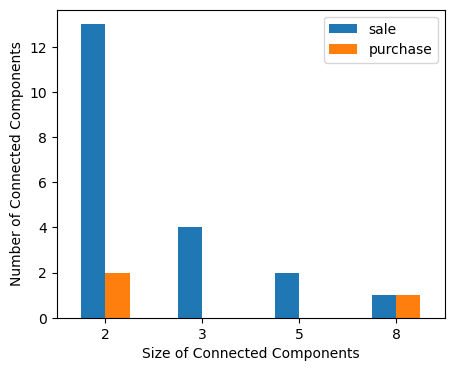

In [220]:
plt.style.use('default')
ser_sale = pd.Series(connected_sale, name = 'sale').value_counts()
ser_purc = pd.Series(connected_purchase, name = 'purchase').value_counts()
f, axes = plt.subplots(1, 1, figsize = (5, 4))
pd.concat([ser_sale, ser_purc], axis = 1).fillna(0).plot(kind = 'bar', rot = 0, ax = axes)
axes.set_ylabel('Number of Connected Components')
axes.set_xlabel('Size of Connected Components');
plt.savefig('Results/component_size')

# Appendix
This section discusses about two things:
1. More complicated commands used with examples: standalone code will be run to illustrate its use
2. Specific code run to ensure quicker research process. This code is not directly related to the research focus. Rather, it serves to improve the efficiency of the whole process

## Quickening Research Process

Even though GNU Parallel has existed for more than a decade, some machines do not have it installed. Thus, the command below is run to install it. Note that GNU Parallel utility should be referenced as `/usr/local/bin/parallel` instead of parallel (which is a `gnu` version) unless an alias is set in `~/.bashrc`

In [4]:
%%bash
whereis parallel

parallel: /usr/bin/parallel /usr/local/bin/parallel /usr/share/man/man1/parallel.1.gz


In [3]:
%%bash
wget http://ftp.gnu.org/gnu/parallel/parallel-20210522.tar.bz2
sudo tar xjf parallel-20210522.tar.bz2
cd parallel-20210522
sudo ./configure && make
sudo make install
cd

checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking whether make supports nested variables... yes
checking whether ln -s works... yes
checking that generated files are newer than configure... done
configure: creating ./config.status
config.status: creating Makefile
config.status: creating src/Makefile
config.status: creating config.h
make  all-recursive
make[1]: Entering directory '/content/parallel-20210522'
Making all in src
make[2]: Entering directory '/content/parallel-20210522/src'
make[2]: Nothing to be done for 'all'.
make[2]: Leaving directory '/content/parallel-20210522/src'
make[2]: Entering directory '/content/parallel-20210522'
make[2]: Leaving directory '/content/parallel-20210522'
make[1]: Leaving directory '/content/parallel-20210522'
Making install in src
make[

--2021-05-25 00:36:56--  http://ftp.gnu.org/gnu/parallel/parallel-20210522.tar.bz2
Resolving ftp.gnu.org (ftp.gnu.org)... 209.51.188.20, 2001:470:142:3::b
Connecting to ftp.gnu.org (ftp.gnu.org)|209.51.188.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2246330 (2.1M) [application/x-bzip2]
Saving to: ‘parallel-20210522.tar.bz2’

     0K .......... .......... .......... .......... ..........  2% 1.86M 1s
    50K .......... .......... .......... .......... ..........  4% 3.74M 1s
   100K .......... .......... .......... .......... ..........  6% 35.8M 1s
   150K .......... .......... .......... .......... ..........  9%  128M 0s
   200K .......... .......... .......... .......... .......... 11% 3.76M 0s
   250K .......... .......... .......... .......... .......... 13% 60.1M 0s
   300K .......... .......... .......... .......... .......... 15%  204M 0s
   350K .......... .......... .......... .......... .......... 18%  227M 0s
   400K .......... .......... ...

Google Cloud Console is used to run `extract.sh`. However, the console quickly loses connection. To resolve this, click events are simulated by inserting the [JavaScript](https://stackoverflow.com/questions/49976573/why-google-cloud-shell-auto-disconnect-after-1-hours) code below to the browser's console

In [ ]:
%%javascript
setInterval(function() {document.elementFromPoint(500, 500).click();}, 30000);

As running the script is power-intensive, this notebook is run on Google Colab. Colab may have session timeout when it is idle even for 20 minutes. However, the whole script runs more than 2 hours. To resolve this, an iterative click simulation is performed in [JavaScript](https://stackoverflow.com/questions/54057011/google-colab-session-timeout)

In [ ]:
%%javascript
function ClickToConnect(){             // only run in Colab
    document.querySelector('#top-toolbar > colab-connect-button').shadowRoot.querySelector('#connect').click();
    console.log("Connecting")
}
setInterval(ClickToConnect, 60*1000)
// clearInterval(ClickToConnect)  // to stop the click event

<IPython.core.display.Javascript object>

`tee` can print the output to files and stdin simulatneously. This is useful for executing the actual code while showing some content in the file for easier understanding. However, one can argue that printing to a file and then using `head` could achieve the same results.  

Is there any difference in terms of time? Will using `tee` slow the output process? The code below outputs the statistics into a file, with the size of the file content as the variable

In [ ]:
%%bash
echo "Approach 1: without saving to a file, use tee to send output to head" >tee_head_time.csv
echo "Number of Rows: Duration (milliseconds)" >>tee_head_time.csv
for ((row_size = 10; row_size < 1000000000; row_size*=10)) do
    start=$(($(date +%s%N)/1000000));
    echo "digit_1,mul2,digit_2,digit_3,digit_4,digit_5,mod3,mod5,doubledigit_1,digit_6,digit_7,digit_8,mod4,doubledigit_2,digit_9,digit_10,digit_11,mod7,triple,doubledigit_3,digit12,digit13,digit14"
    for i in $(seq 1 1 $row_size); do 
        tmp=$(($i%10));
        echo $tmp,$(($(($i*2))%10)),$tmp,$tmp,$tmp,$tmp,$(($tmp % 3)),$(($tmp % 5)),$tmp$tmp,$tmp,$tmp,$tmp,$(($tmp % 4)),$tmp$tmp,$tmp,$tmp,$tmp,$(($tmp % 7)),$tmp$tmp$tmp,$tmp$tmp,$tmp,$tmp,$(($tmp % 4)); 
    done | tee | head 
    end=$(($(date +%s%N)/1000000))
    echo $row_size: $(($end-$start)) >>tee_head_time.csv
done;

echo "Approach 2: save output in a file, then use head utility" >>tee_head_time.csv
echo "Number of Rows: Duration (milliseconds)" >>tee_head_time.csv
for ((row_size = 10; row_size < 1000000000; row_size*=10)) do
    start=$(($(date +%s%N)/1000000));
    echo "digit_1,mul2,digit_2,digit_3,digit_4,digit_5,mod3,mod5,doubledigit_1,digit_6,digit_7,digit_8,mod4,doubledigit_2,digit_9,digit_10,digit_11,mod7,triple,doubledigit_3,digit12,digit13,digit14" >test.csv
    for i in $(seq 1 1 $row_size); do 
        tmp=$(($i%10));
        echo $tmp,$(($(($i*2))%10)),$tmp,$tmp,$tmp,$tmp,$(($tmp % 3)),$(($tmp % 5)),$tmp$tmp,$tmp,$tmp,$tmp,$(($tmp % 4)),$tmp$tmp,$tmp,$tmp,$tmp,$(($tmp % 7)),$tmp$tmp$tmp,$tmp$tmp,$tmp,$tmp,$(($tmp % 4)); 
    done >>test.csv
    head test.csv
    end=$(($(date +%s%N)/1000000))
    echo $row_size: $(($end-$start)) >>tee_head_time.csv
    rm test.csv;
done;

# getting milliseconds [https://stackoverflow.com/questions/16548528/command-to-get-time-in-milliseconds]

digit_1,mul2,digit_2,digit_3,digit_4,digit_5,mod3,mod5,doubledigit_1,digit_6,digit_7,digit_8,mod4,doubledigit_2,digit_9,digit_10,digit_11,mod7,triple,doubledigit_3,digit12,digit13,digit14
1,2,1,1,1,1,1,1,11,1,1,1,1,11,1,1,1,1,111,11,1,1,1
2,4,2,2,2,2,2,2,22,2,2,2,2,22,2,2,2,2,222,22,2,2,2
3,6,3,3,3,3,0,3,33,3,3,3,3,33,3,3,3,3,333,33,3,3,3
4,8,4,4,4,4,1,4,44,4,4,4,0,44,4,4,4,4,444,44,4,4,0
5,0,5,5,5,5,2,0,55,5,5,5,1,55,5,5,5,5,555,55,5,5,1
6,2,6,6,6,6,0,1,66,6,6,6,2,66,6,6,6,6,666,66,6,6,2
7,4,7,7,7,7,1,2,77,7,7,7,3,77,7,7,7,0,777,77,7,7,3
8,6,8,8,8,8,2,3,88,8,8,8,0,88,8,8,8,1,888,88,8,8,0
9,8,9,9,9,9,0,4,99,9,9,9,1,99,9,9,9,2,999,99,9,9,1
0,0,0,0,0,0,0,0,00,0,0,0,0,00,0,0,0,0,000,00,0,0,0
digit_1,mul2,digit_2,digit_3,digit_4,digit_5,mod3,mod5,doubledigit_1,digit_6,digit_7,digit_8,mod4,doubledigit_2,digit_9,digit_10,digit_11,mod7,triple,doubledigit_3,digit12,digit13,digit14
1,2,1,1,1,1,1,1,11,1,1,1,1,11,1,1,1,1,111,11,1,1,1
2,4,2,2,2,2,2,2,22,2,2,2,2,22,2,2,2,2,222,22,2,2,2
3,6,3,3,3,3,